In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import json
import cvxpy as cp
from collections import defaultdict, Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

plt.style.use('ggplot')

np.random.seed(2)

(CVXPY) Apr 10 07:30:03 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.12.4544). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 10 07:30:03 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.12.4544). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [ ]:
def sample_utility(m, n, sample_m,sample_n,W):
    rng = np.random.default_rng()

    users = rng.choice(m, size=sample_m, replace=False)
    items = rng.choice(n, size=sample_n, replace=False)
    return W[users][:,items]

def sample_candidate_items(rel_matrix_users: np.ndarray, n_candidates: int) -> np.ndarray:
    top_items = np.argsort(rel_matrix_users, axis=1)[:, -n_candidates:]
    unique_items = np.unique(top_items)
    return rel_matrix_users[np.arange(rel_matrix_users.shape[0])[:, None], unique_items]

def sample_users_from_groups(users_count: int, items_count: int, groups_map: dict[int, str], group_name: str, data: np.ndarray, naive_sampling: bool = True) -> tuple[np.ndarray, list[int]]:
    users_per_group = {group: max(round(users_count * count / len(groups_map)), 1) for group, count in Counter([i[group_name] for i in groups_map]).items()}
    group_users = defaultdict(list)
    for row in groups_map:
        group_users[row[group_name]].append(row["user_id"])

    sampled_users = []
    for group, users in group_users.items():
        sampled_users.extend(np.random.choice(users, users_per_group[group], replace=False))

    rng = np.random.default_rng()
    if naive_sampling:
        items = rng.choice(data.shape[1], size=items_count, replace=False)
        return data[sampled_users][:, items], sampled_users

    rel_matrix_sampled = data[sampled_users]
    top_items = sample_candidate_items(rel_matrix_sampled, items_count)
    return top_items, sampled_users

def best_unconstrained(rel_matrix: np.ndarray, k_rec: int) -> cp.Problem:
    n_u, n_i = rel_matrix.shape
    x_alloc = cp.Variable((n_u, n_i), boolean=True)

    # constraints
    constraints = []
    # recommend k items
    constraints.append(cp.sum(x_alloc, axis=1) == k_rec)

    problem = cp.Problem(cp.Maximize(cp.mean(cp.sum(cp.multiply(x_alloc, rel_matrix), axis=1))), constraints)
    problem.solve(solver=cp.SCIP)

    return problem






def constrained_maxmin_item_given_user(rel_matrix: np.ndarray, k_rec: int) -> cp.Problem:
    x_alloc = cp.Variable(rel_matrix.shape, boolean=True)

    # constraints
    constraints = [
        # recommend k items
        cp.sum(x_alloc, axis=1) == k_rec,
    ]

    # maximize the minimal item utility
    problem = cp.Problem(
        cp.Maximize(cp.min(cp.sum(x_alloc, axis=0))),
        constraints,
    )
    problem.solve(solver=cp.SCIP)

    return problem


def get_user_curve(rel_matrix: np.ndarray, k_rec: int, gamma_points: list[float]) -> list[tuple[float, float]]:
    import seaborn as sns

    # Now, do the actual convex optimization
    item_min_max = constrained_maxmin_item_given_user(rel_matrix, k_rec).value
    user_min_max = constrained_maxmin_user_given_item(rel_matrix, k_rec, 0)
    user_min_max_val = user_min_max.value
    user_min_max_val_user_level = (user_min_max.variables()[0].value * rel_matrix).sum(axis=1)

    pairs = []
    u_utils = []
    i_utils = []
    for gamma_item in gamma_points:
        v_user_result = constrained_maxmin_user_given_item(
            rel_matrix, k_rec, gamma_item * item_min_max,
        )
        weights = v_user_result.variables()[0].value
        weights = weights.flatten()
        plt.figure(figsize=(10, 10), dpi=300)
        sns.displot(weights, bins=1000)
        plt.savefig(f"./media22/weights_{gamma_item}.png")
        u_utils.append((rel_matrix * np.round(v_user_result.variables()[0].value)).sum(axis=1) / user_min_max_val_user_level)
        i_utils.append(v_user_result.variables()[0].value.sum(axis=0))
        #u_utils.append((rel_matrix * v_user_result.variables()[0].value).sum(axis=1))
        pair = (gamma_item, v_user_result.value / user_min_max_val)
        pairs.append(pair)

    return pairs, u_utils, i_utils


def get_curves_user_groups(rel_matrix: np.ndarray, u_sample: int, i_sample: int, n_runs: int, gamma_points: list[float], k_rec: int, groups_map: list[dict[str, int]], group_name: str, naive_sampling: bool = True) -> tuple[np.ndarray, list[int], list[float]]:
    all_empirical_pairs = []
    users_ids = []
    u_utils = []
    for _ in tqdm(range(n_runs)):
        rel_matrix_sampled, _users_ids = sample_users_from_groups(u_sample, i_sample, groups_map, group_name, rel_matrix, naive_sampling)
        users_ids.append(_users_ids)

        pairs, _u_utils, _ = get_user_curve(rel_matrix_sampled, k_rec, gamma_points)
        u_utils.append(_u_utils)
        all_empirical_pairs.append(pairs)

    return np.array(all_empirical_pairs), users_ids, u_utils

def get_curves_user_default(rel_matrix: np.ndarray, u_sample: int, i_sample: int, n_runs: int, gamma_points: list[float], k_rec: int, groups_map: list[dict[str, int]], group_name: str, naive_sampling: bool = True) -> tuple[np.ndarray, list[int], list[float]]:
    all_empirical_pairs = []
    users_ids = []
    u_utils = []
    i_utils = []
    for _ in tqdm(range(n_runs)):
        rel_matrix_sampled = sample_utility(rel_matrix.shape[0], rel_matrix.shape[1], u_sample, i_sample, rel_matrix)
        pairs, _u_utils, _i_utils  = get_user_curve(rel_matrix_sampled, k_rec, gamma_points)
        u_utils.append(_u_utils)
        i_utils.append(_i_utils)
        all_empirical_pairs.append(pairs)

    return np.array(all_empirical_pairs), users_ids, u_utils, i_utils


In [7]:
with open("amazon_predictions.npy", "rb") as f:
    u_rel_matrx = np.load(f)

with open("amazon_user_groups.json", "r") as f:
    user_groups = json.load(f)

N_USERS, N_ITEMS = u_rel_matrx.shape

In [5]:
# list matplotlib colors
colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])
colors

['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']

In [4]:
user_size = 200
items_size = 100
top_k = 1
n_runs = 10
gamma_points = np.linspace(0, 1, 10)
group_name = "usage_group"
all_empirical_pairs, users_ids, u_utils, i_utils = get_curves_user_default(u_rel_matrx, user_size, items_size, n_runs, gamma_points, top_k, user_groups, group_name)

plt.figure(figsize=(10, 6), dpi=300)
plt.title("Consumer and producer utility tradeoff for retrieving k=1 items")
plt.plot(gamma_points, np.mean(all_empirical_pairs[:,:,1], axis=0), color='#348ABD', marker='s', markersize=2, label='Consumer utility')
standard_err = np.std(all_empirical_pairs[:,:,1], axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(all_empirical_pairs[:,:,1], axis=0) - 2 * standard_err, np.mean(all_empirical_pairs[:,:,1], axis=0) + 2*standard_err, alpha=0.3, color='#348ABD')
plt.plot(gamma_points, np.mean(i_utils, axis=0), color='#8EBA42', marker='v', markersize=2, label='Producer utility')
standard_err = np.std(i_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(i_utils, axis=0) - 2 * standard_err, np.mean(i_utils, axis=0) + 2*standard_err, alpha=0.3, color='#8EBA42')
plt.ylabel('Normalized min utility guaranteed')
plt.legend()
plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
plt.ylim([0,1.1])
plt.savefig("./media11/producer_consumer_tradeoff_k1.png")

  0%|          | 0/10 [00:02<?, ?it/s]

pressed CTRL-C 1 times (5 times for forcing termination)


SolverError: Solver 'SCIP' failed. Try another solver, or solve with verbose=True for more information.

  0%|          | 0/10 [00:00<?, ?it/s]

19.999999999999993


 10%|█         | 1/10 [00:07<01:08,  7.60s/it]

19.999999999999993


 20%|██        | 2/10 [00:16<01:05,  8.23s/it]

19.999999999999993


 30%|███       | 3/10 [00:24<00:57,  8.14s/it]

19.999999999999993


 40%|████      | 4/10 [00:32<00:48,  8.04s/it]

19.999999999999993


 50%|█████     | 5/10 [00:39<00:38,  7.77s/it]

19.999999999999993


 60%|██████    | 6/10 [00:47<00:31,  7.86s/it]

19.999999999999993


 70%|███████   | 7/10 [00:56<00:25,  8.33s/it]

19.999999999999993


 80%|████████  | 8/10 [01:04<00:16,  8.22s/it]

19.999999999999993


 90%|█████████ | 9/10 [01:12<00:07,  7.93s/it]

19.999999999999993


100%|██████████| 10/10 [01:19<00:00,  7.95s/it]


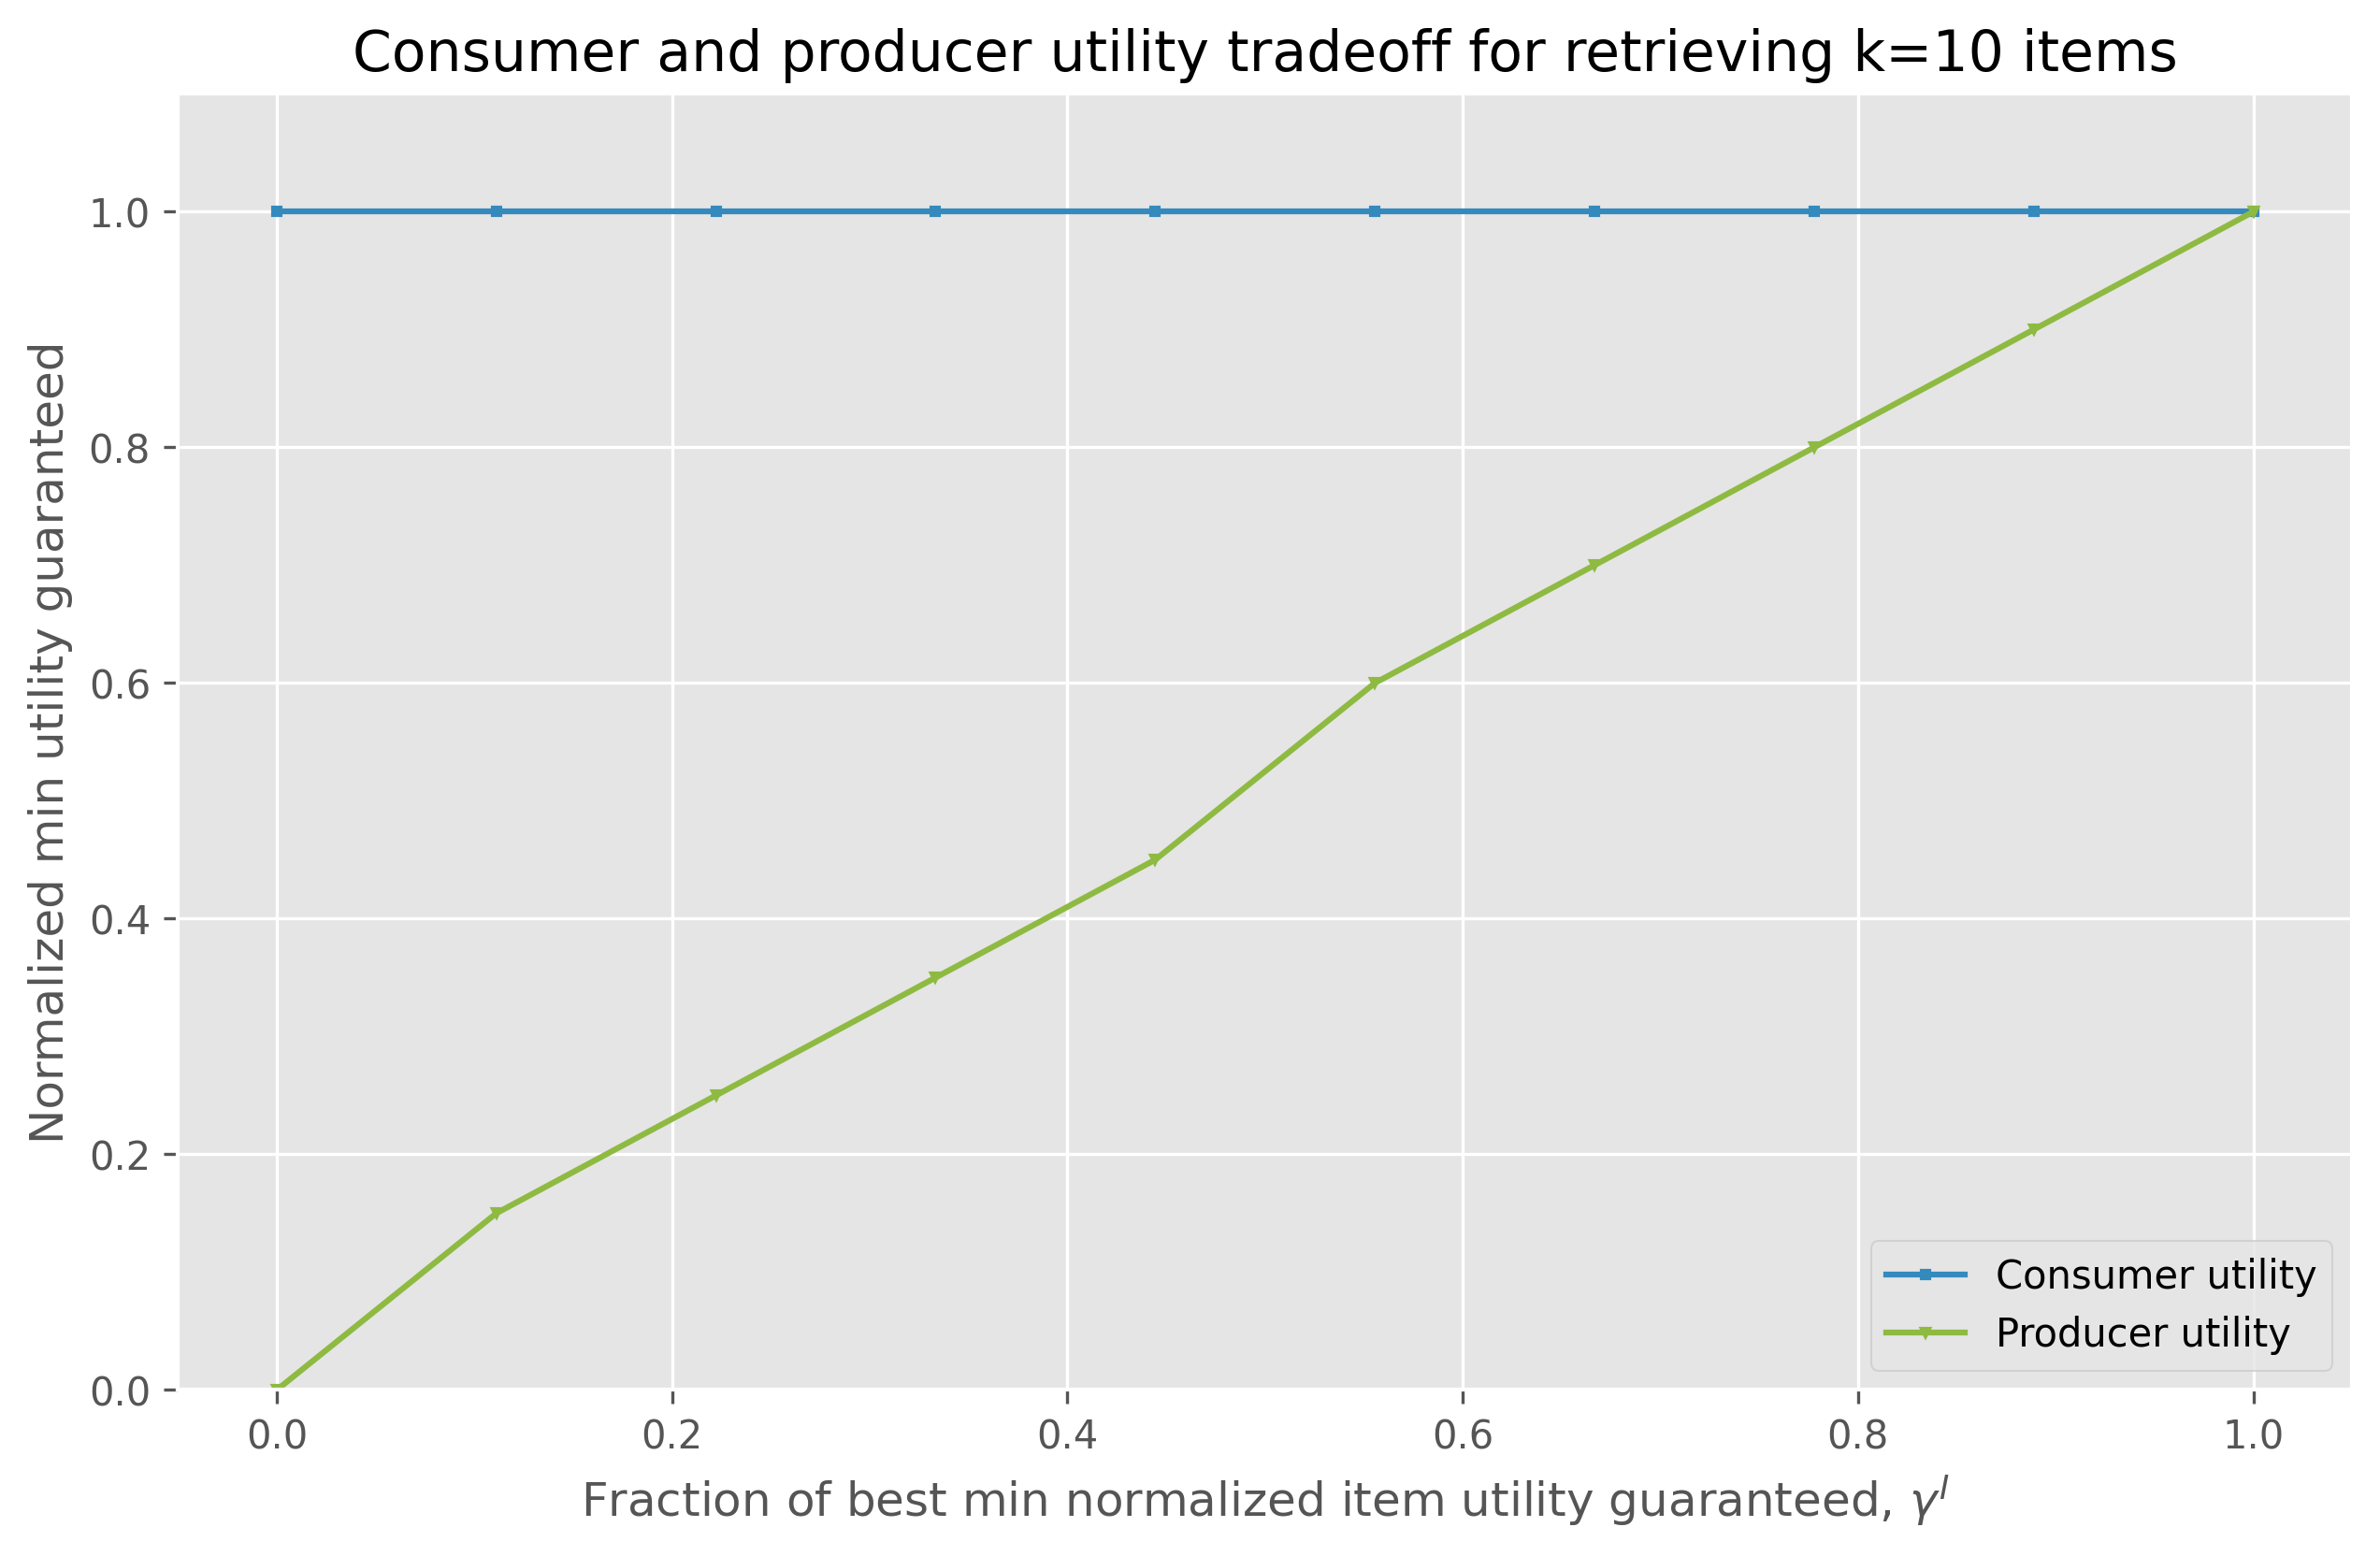

In [28]:
user_size = 200
items_size = 100
top_k = 10
n_runs = 10
gamma_points = np.linspace(0, 1, 10)
group_name = "usage_group"
all_empirical_pairs, users_ids, u_utils, i_utils = get_curves_user_default(u_rel_matrx, user_size, items_size, n_runs, gamma_points, top_k, user_groups, group_name)

plt.figure(figsize=(10, 6), dpi=300)
plt.title("Consumer and producer utility tradeoff for retrieving k=10 items")
plt.plot(gamma_points, np.mean(all_empirical_pairs[:,:,1], axis=0), color='#348ABD', marker='s', markersize=2, label='Consumer utility')
standard_err = np.std(all_empirical_pairs[:,:,1], axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(all_empirical_pairs[:,:,1], axis=0) - 2 * standard_err, np.mean(all_empirical_pairs[:,:,1], axis=0) + 2*standard_err, alpha=0.3, color='#348ABD')
plt.plot(gamma_points, np.mean(i_utils, axis=0), color='#8EBA42', marker='v', markersize=2, label='Producer utility')
standard_err = np.std(i_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(i_utils, axis=0) - 2 * standard_err, np.mean(i_utils, axis=0) + 2*standard_err, alpha=0.3, color='#8EBA42')
plt.ylabel('Normalized min utility guaranteed')
plt.legend()
plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
plt.ylim([0,1.1])
plt.savefig("./media10/producer_consumer_tradeoff_k10.png")

<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:40: SyntaxWarning: invalid escape sequence '\g'
<>:63: SyntaxWarning: invalid escape sequence '\g'
<>:86: SyntaxWarning: invalid escape sequence '\g'
<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:40: SyntaxWarning: invalid escape sequence '\g'
<>:63: SyntaxWarning: invalid escape sequence '\g'
<>:86: SyntaxWarning: invalid escape sequence '\g'
/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_24295/2247435845.py:17: SyntaxWarning: invalid escape sequence '\g'
  plt.suptitle("Producer utility frequency for retrieving k=10 items with different number of items, $\gamma^I$=0.1")
/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_24295/2247435845.py:40: SyntaxWarning: invalid escape sequence '\g'
  plt.suptitle("Producer utility frequency for retrieving k=10 items with different number of items, $\gamma^I$=0.5")
/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_24295/2247435845.py:63: SyntaxWarning: inva

100%|██████████| 1/1 [01:41<00:00, 101.56s/it]


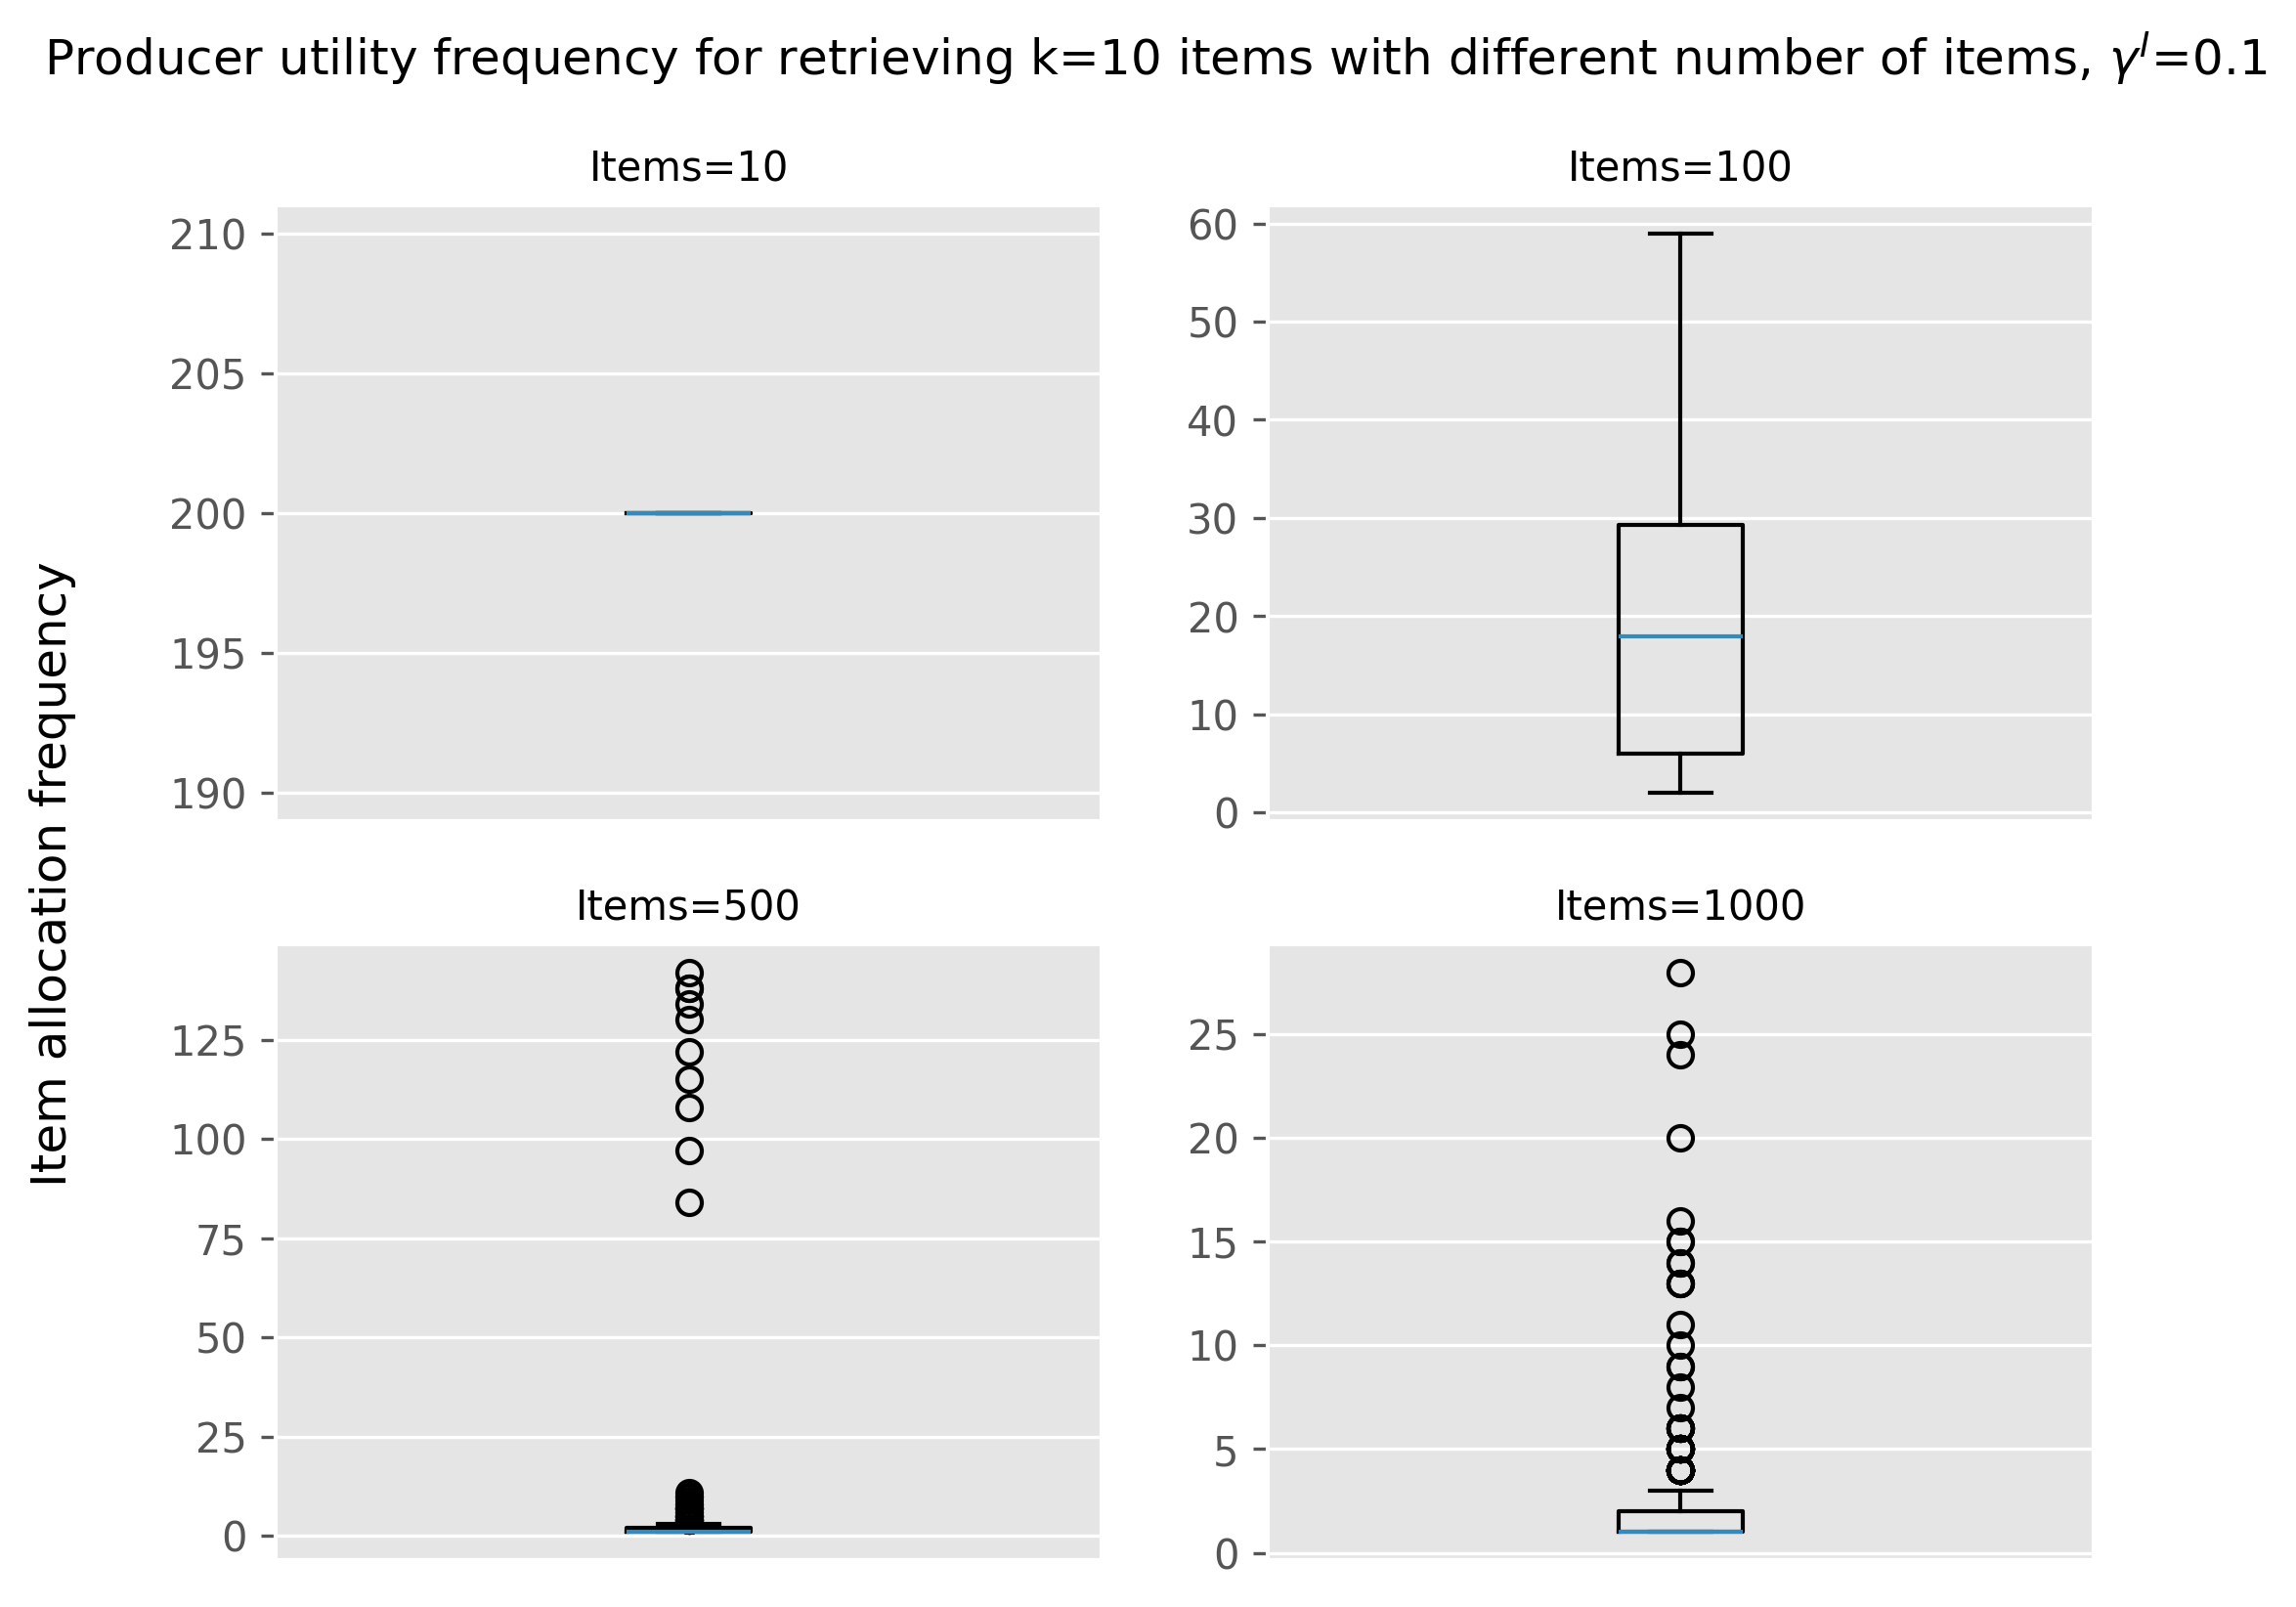

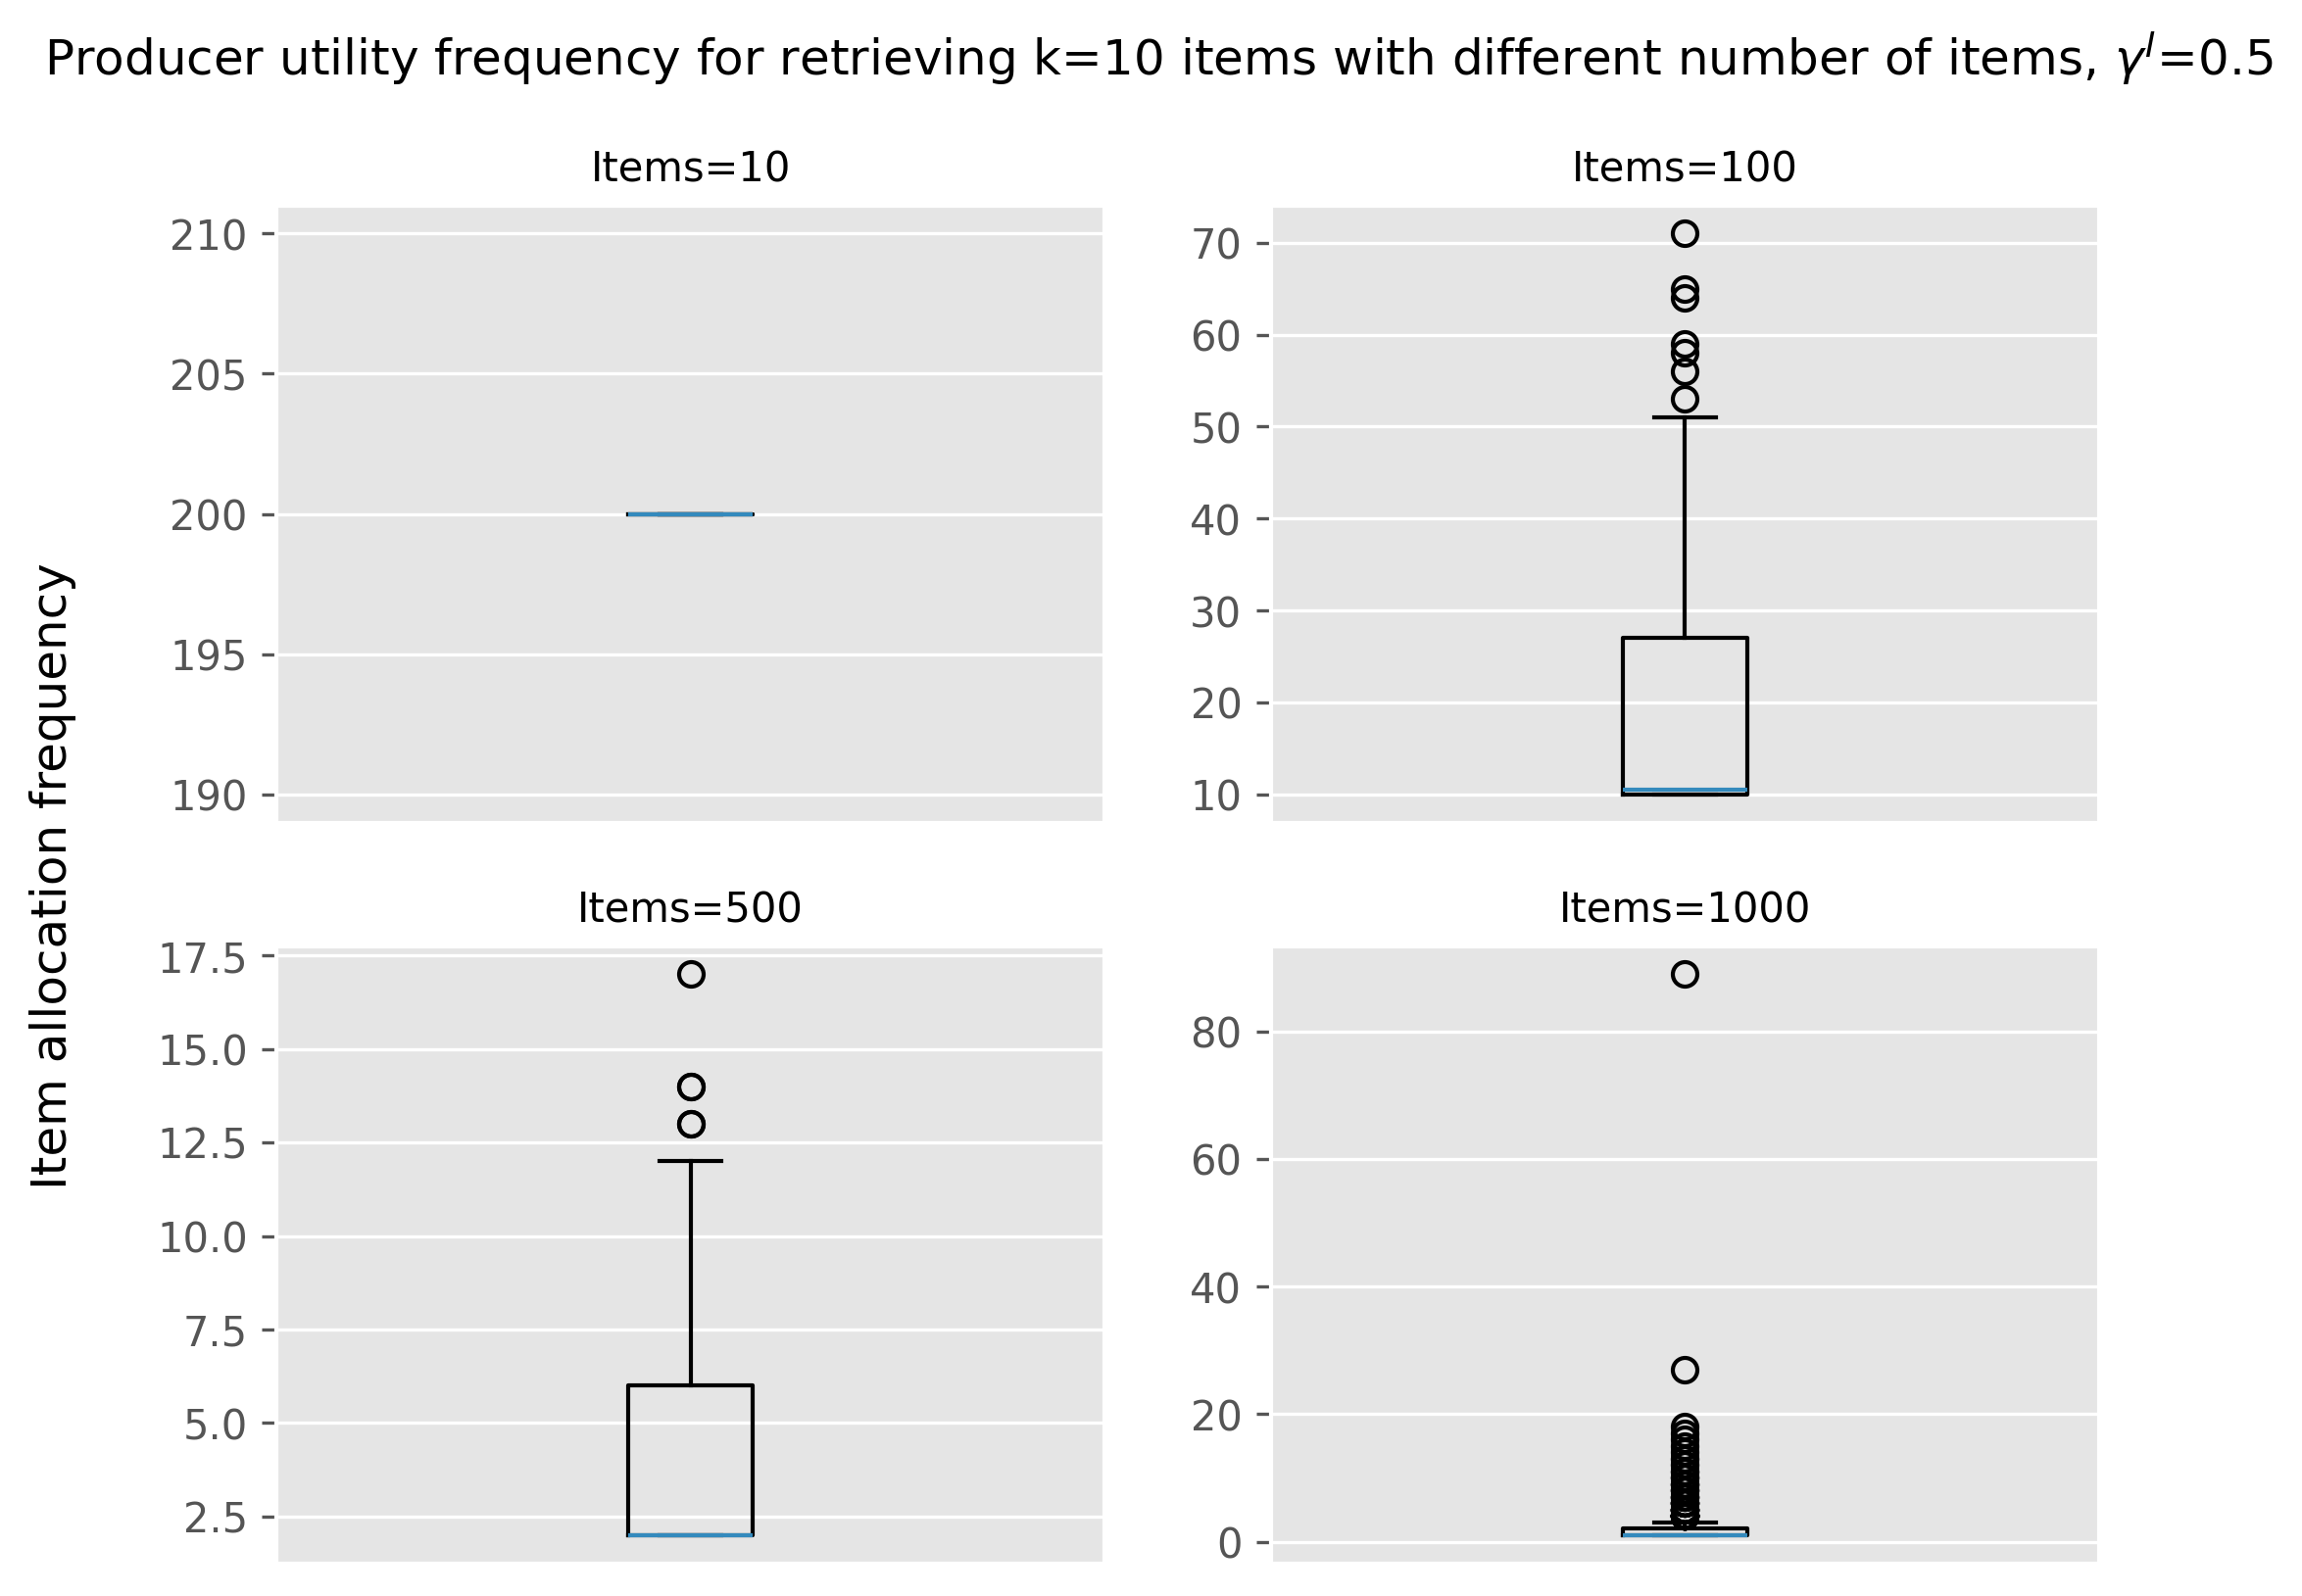

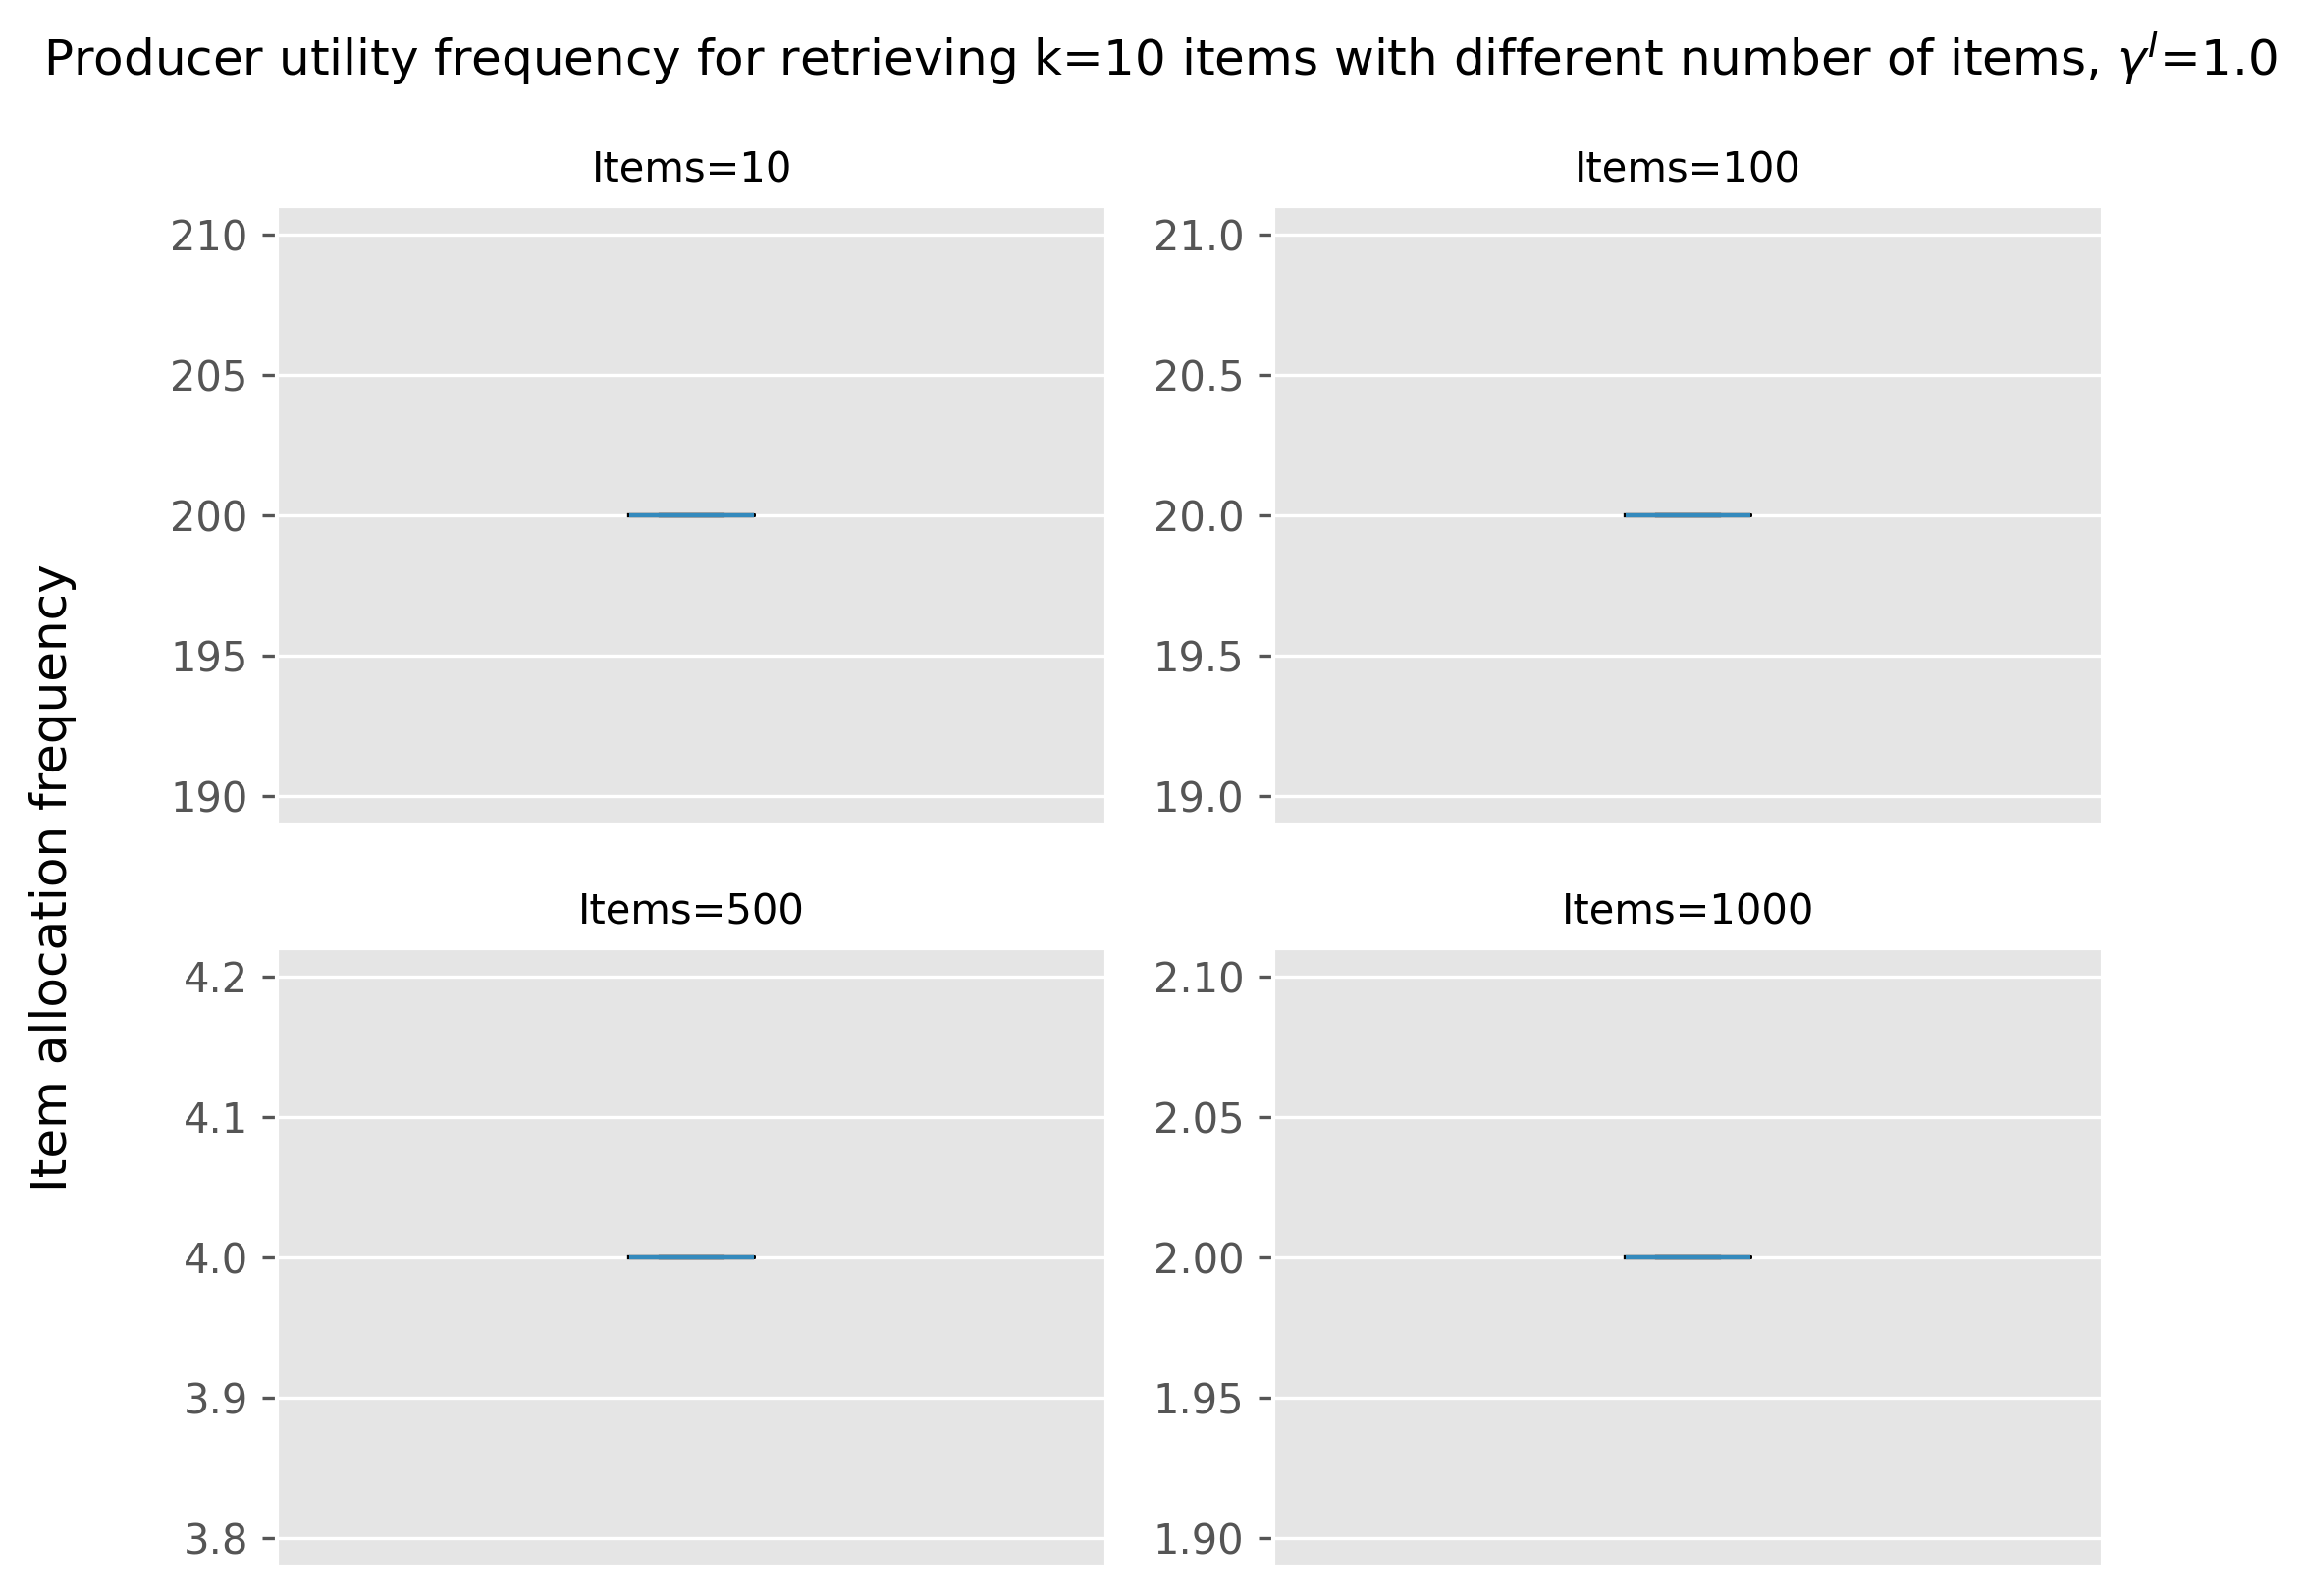

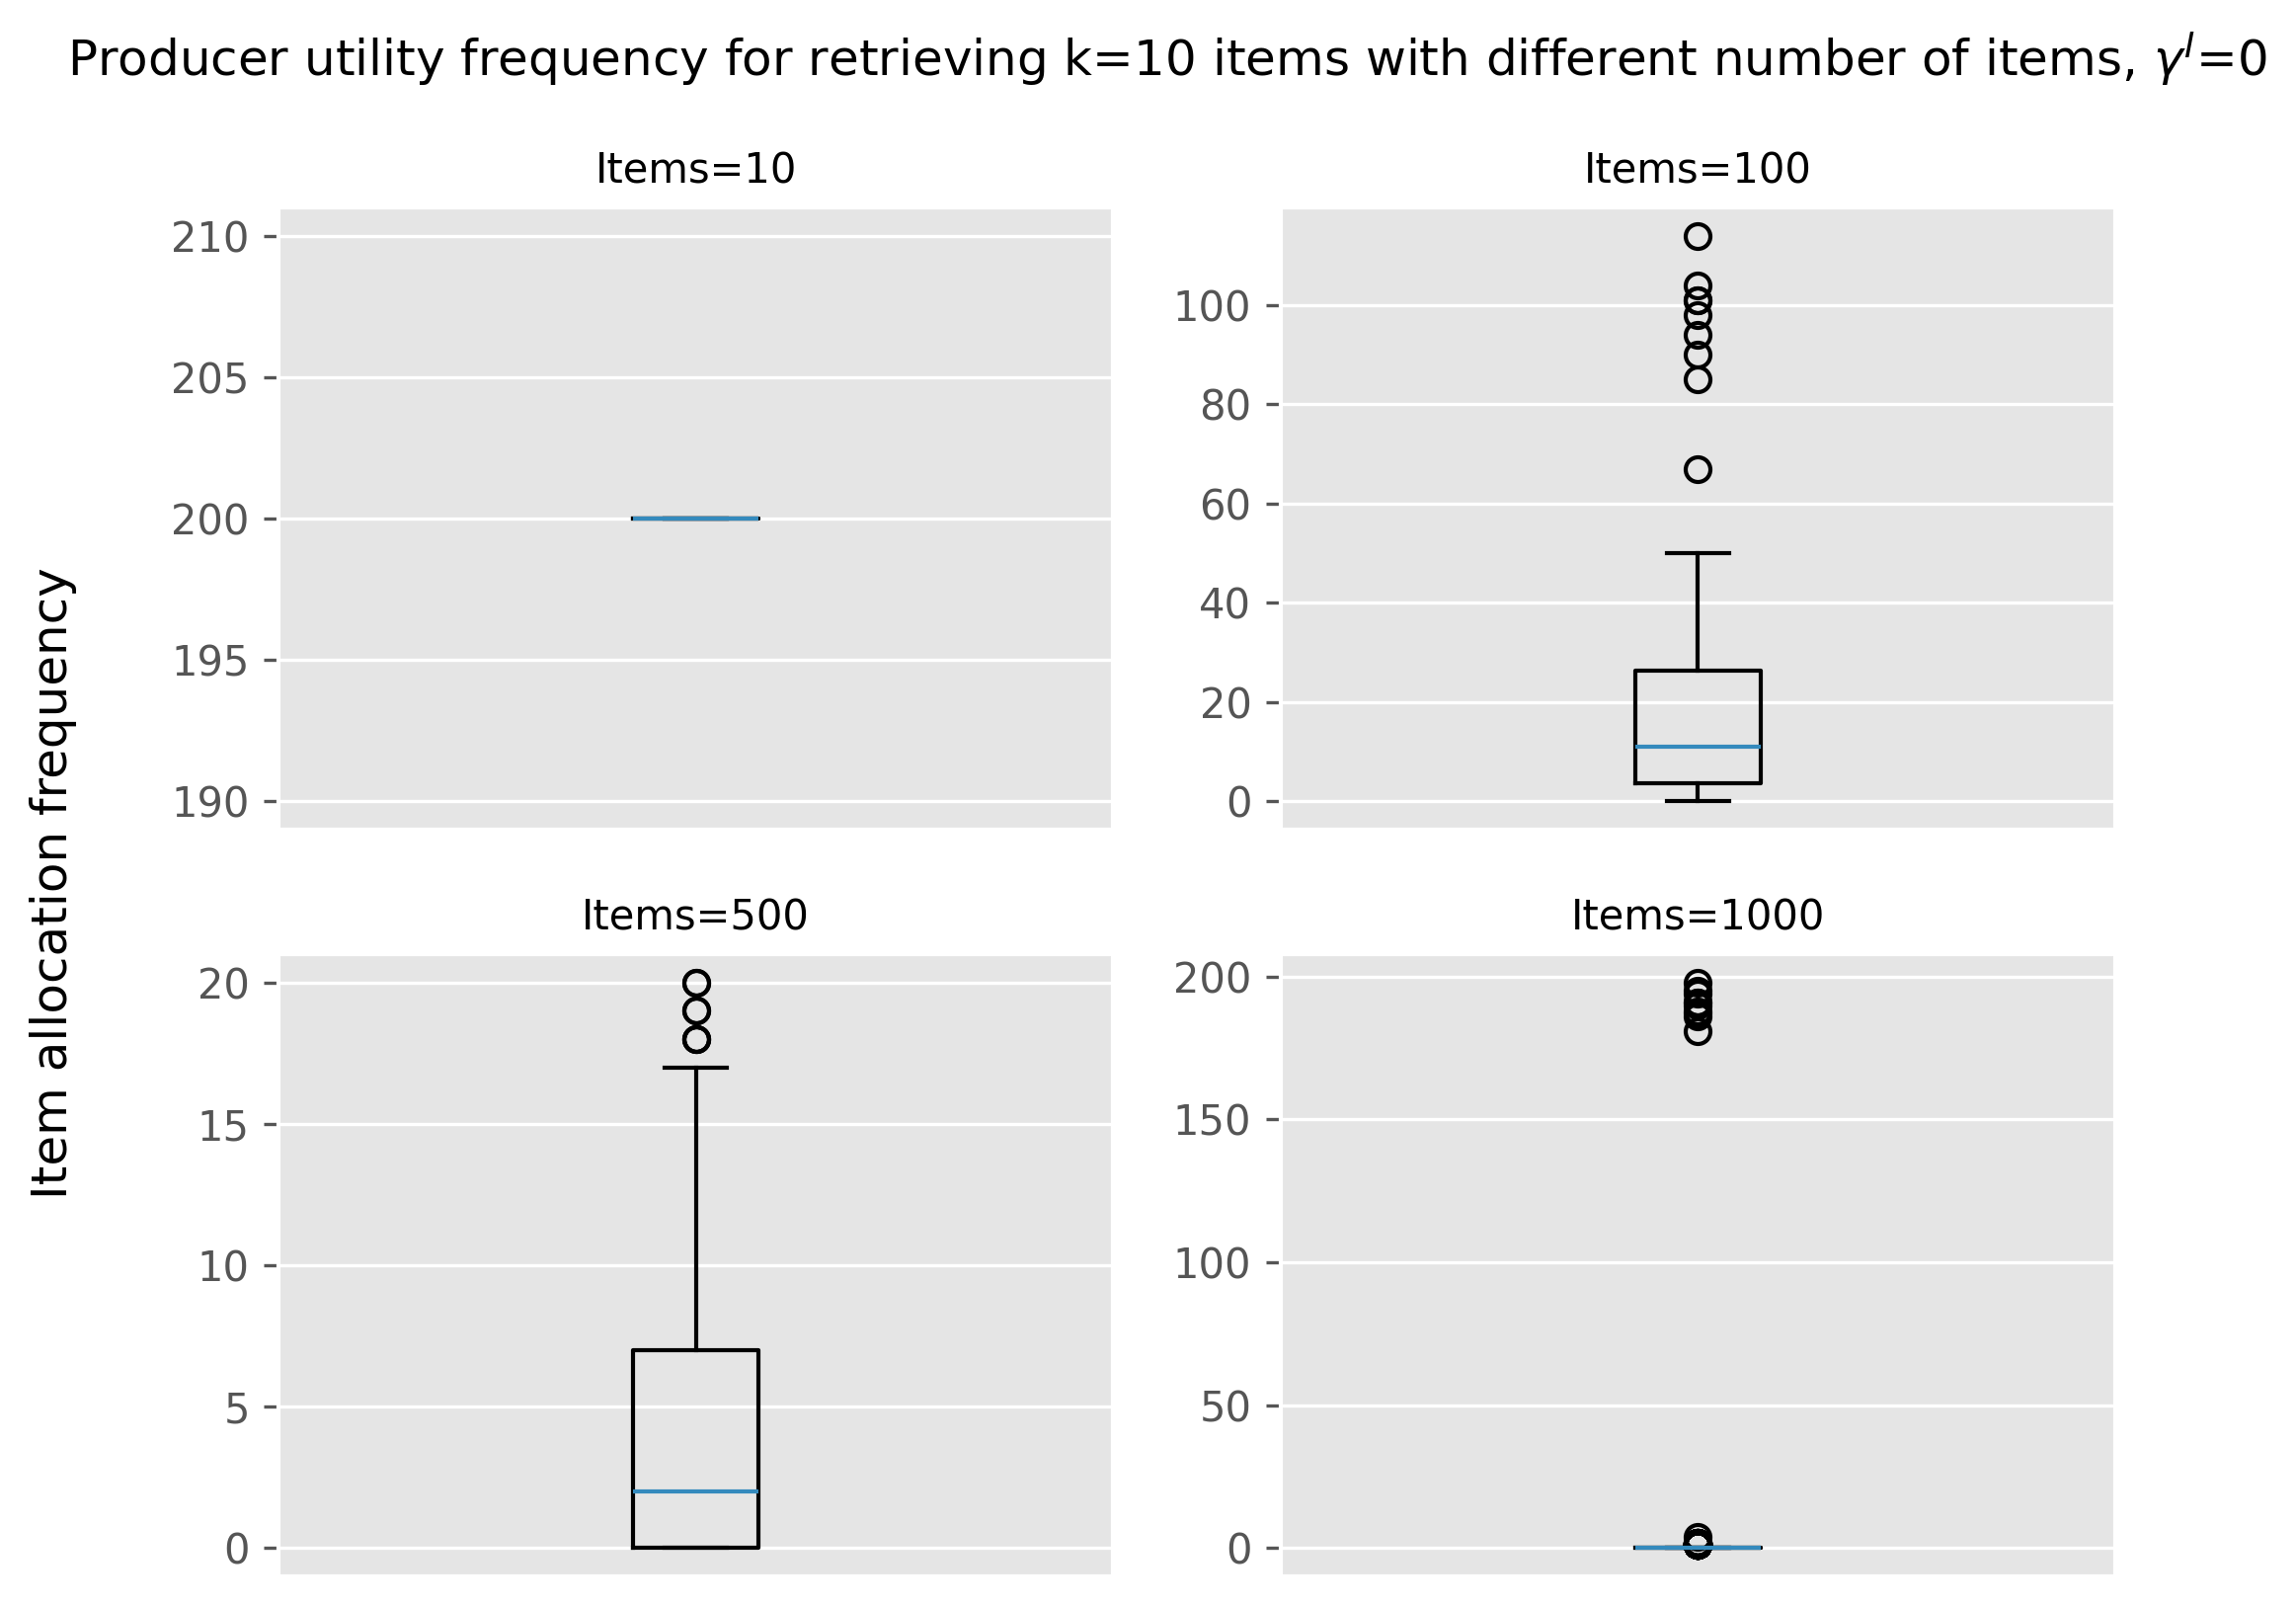

In [87]:
user_size = 200
items_size = 10
top_k = 10
n_runs = 1
gamma_points = np.linspace(0, 1, 10)
res = [
    get_curves_user_default(u_rel_matrx, user_size, 10, 1, [0.1], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 100, 1, [0.1], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 500, 1, [0.1], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 1000, 1, [0.1], top_k, user_groups, group_name),
]

i_utils = [res[i][3][0][0] for i in range(4)]
items = [10, 100, 500, 1000]
fig = plt.figure(figsize=(8, 6), dpi=300)
plt.subplot(2, 2, 1)
plt.suptitle("Producer utility frequency for retrieving k=10 items with different number of items, $\gamma^I$=0.1")
for i, data in enumerate(i_utils):
    # plot hist in 4 subplots
    plt.subplot(2, 2, i+1)
    plt.title(f"Items={items[i]}", fontsize=10)
    plt.boxplot(data)
    # hide x-axis
    plt.gca().axes.get_xaxis().set_visible(False)

fig.supylabel('Item allocation frequency')
plt.savefig("./media10/producer_utility_frequency_g01.png")

res = [
    get_curves_user_default(u_rel_matrx, user_size, 10, 1, [0.5], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 100, 1, [0.5], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 500, 1, [0.5], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 1000, 1, [0.5], top_k, user_groups, group_name),
]

i_utils = [res[i][3][0][0] for i in range(4)]
items = [10, 100, 500, 1000]
fig = plt.figure(figsize=(8, 6), dpi=300)
plt.subplot(2, 2, 1)
plt.suptitle("Producer utility frequency for retrieving k=10 items with different number of items, $\gamma^I$=0.5")
for i, data in enumerate(i_utils):
    # plot hist in 4 subplots
    plt.subplot(2, 2, i+1)
    plt.title(f"Items={items[i]}", fontsize=10)
    plt.boxplot(data)
    # hide x-axis
    plt.gca().axes.get_xaxis().set_visible(False)

fig.supylabel('Item allocation frequency')
plt.savefig("./media10/producer_utility_frequency_g05.png")

res = [
    get_curves_user_default(u_rel_matrx, user_size, 10, 1, [1], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 100, 1, [1], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 500, 1, [1], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 1000, 1, [1], top_k, user_groups, group_name),
]

i_utils = [res[i][3][0][0] for i in range(4)]
items = [10, 100, 500, 1000]
fig = plt.figure(figsize=(8, 6), dpi=300)
plt.subplot(2, 2, 1)
plt.suptitle("Producer utility frequency for retrieving k=10 items with different number of items, $\gamma^I$=1.0")
for i, data in enumerate(i_utils):
    # plot hist in 4 subplots
    plt.subplot(2, 2, i+1)
    plt.title(f"Items={items[i]}", fontsize=10)
    plt.boxplot(data)
    # hide x-axis
    plt.gca().axes.get_xaxis().set_visible(False)

fig.supylabel('Item allocation frequency')
plt.savefig("./media10/producer_utility_frequency_g1.png")

res = [
    get_curves_user_default(u_rel_matrx, user_size, 10, 1, [0], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 100, 1, [0], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 500, 1, [0], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 1000, 1, [0], top_k, user_groups, group_name),
]

i_utils = [res[i][3][0][0] for i in range(4)]
items = [10, 100, 500, 1000]
fig = plt.figure(figsize=(8, 6), dpi=300)
plt.subplot(2, 2, 1)
plt.suptitle("Producer utility frequency for retrieving k=10 items with different number of items, $\gamma^I$=0")
for i, data in enumerate(i_utils):
    # plot hist in 4 subplots
    plt.subplot(2, 2, i+1)
    plt.title(f"Items={items[i]}", fontsize=10)
    plt.boxplot(data)
    # hide x-axis
    plt.gca().axes.get_xaxis().set_visible(False)

fig.supylabel('Item allocation frequency')
plt.savefig("./media10/producer_utility_frequency_g0.png")

In [ ]:
user_size = 200
items_size = 10
top_k = 10
n_runs = 10
gamma_points = np.linspace(0, 1, 10)
res = [
    get_curves_user_default(u_rel_matrx, user_size, 10, 1, [0.1], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 100, 1, [0.1], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 500, 1, [0.1], top_k, user_groups, group_name),
    get_curves_user_default(u_rel_matrx, user_size, 1000, 1, [0.1], top_k, user_groups, group_name),
]

i_utils = [res[i][3][0][0] for i in range(4)]
items = [10, 100, 500, 1000]
fig = plt.figure(figsize=(8, 6), dpi=300)
plt.subplot(2, 2, 1)
plt.suptitle("Producer utility frequency for retrieving k=10 items with different number of items, $\gamma^I$=0.1")
for i, data in enumerate(i_utils):
    # plot hist in 4 subplots
    plt.subplot(2, 2, i+1)
    plt.title(f"Items={items[i]}", fontsize=10)
    plt.boxplot(data)
    # hide x-axis
    plt.gca().axes.get_xaxis().set_visible(False)

fig.supylabel('Item allocation frequency')

100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


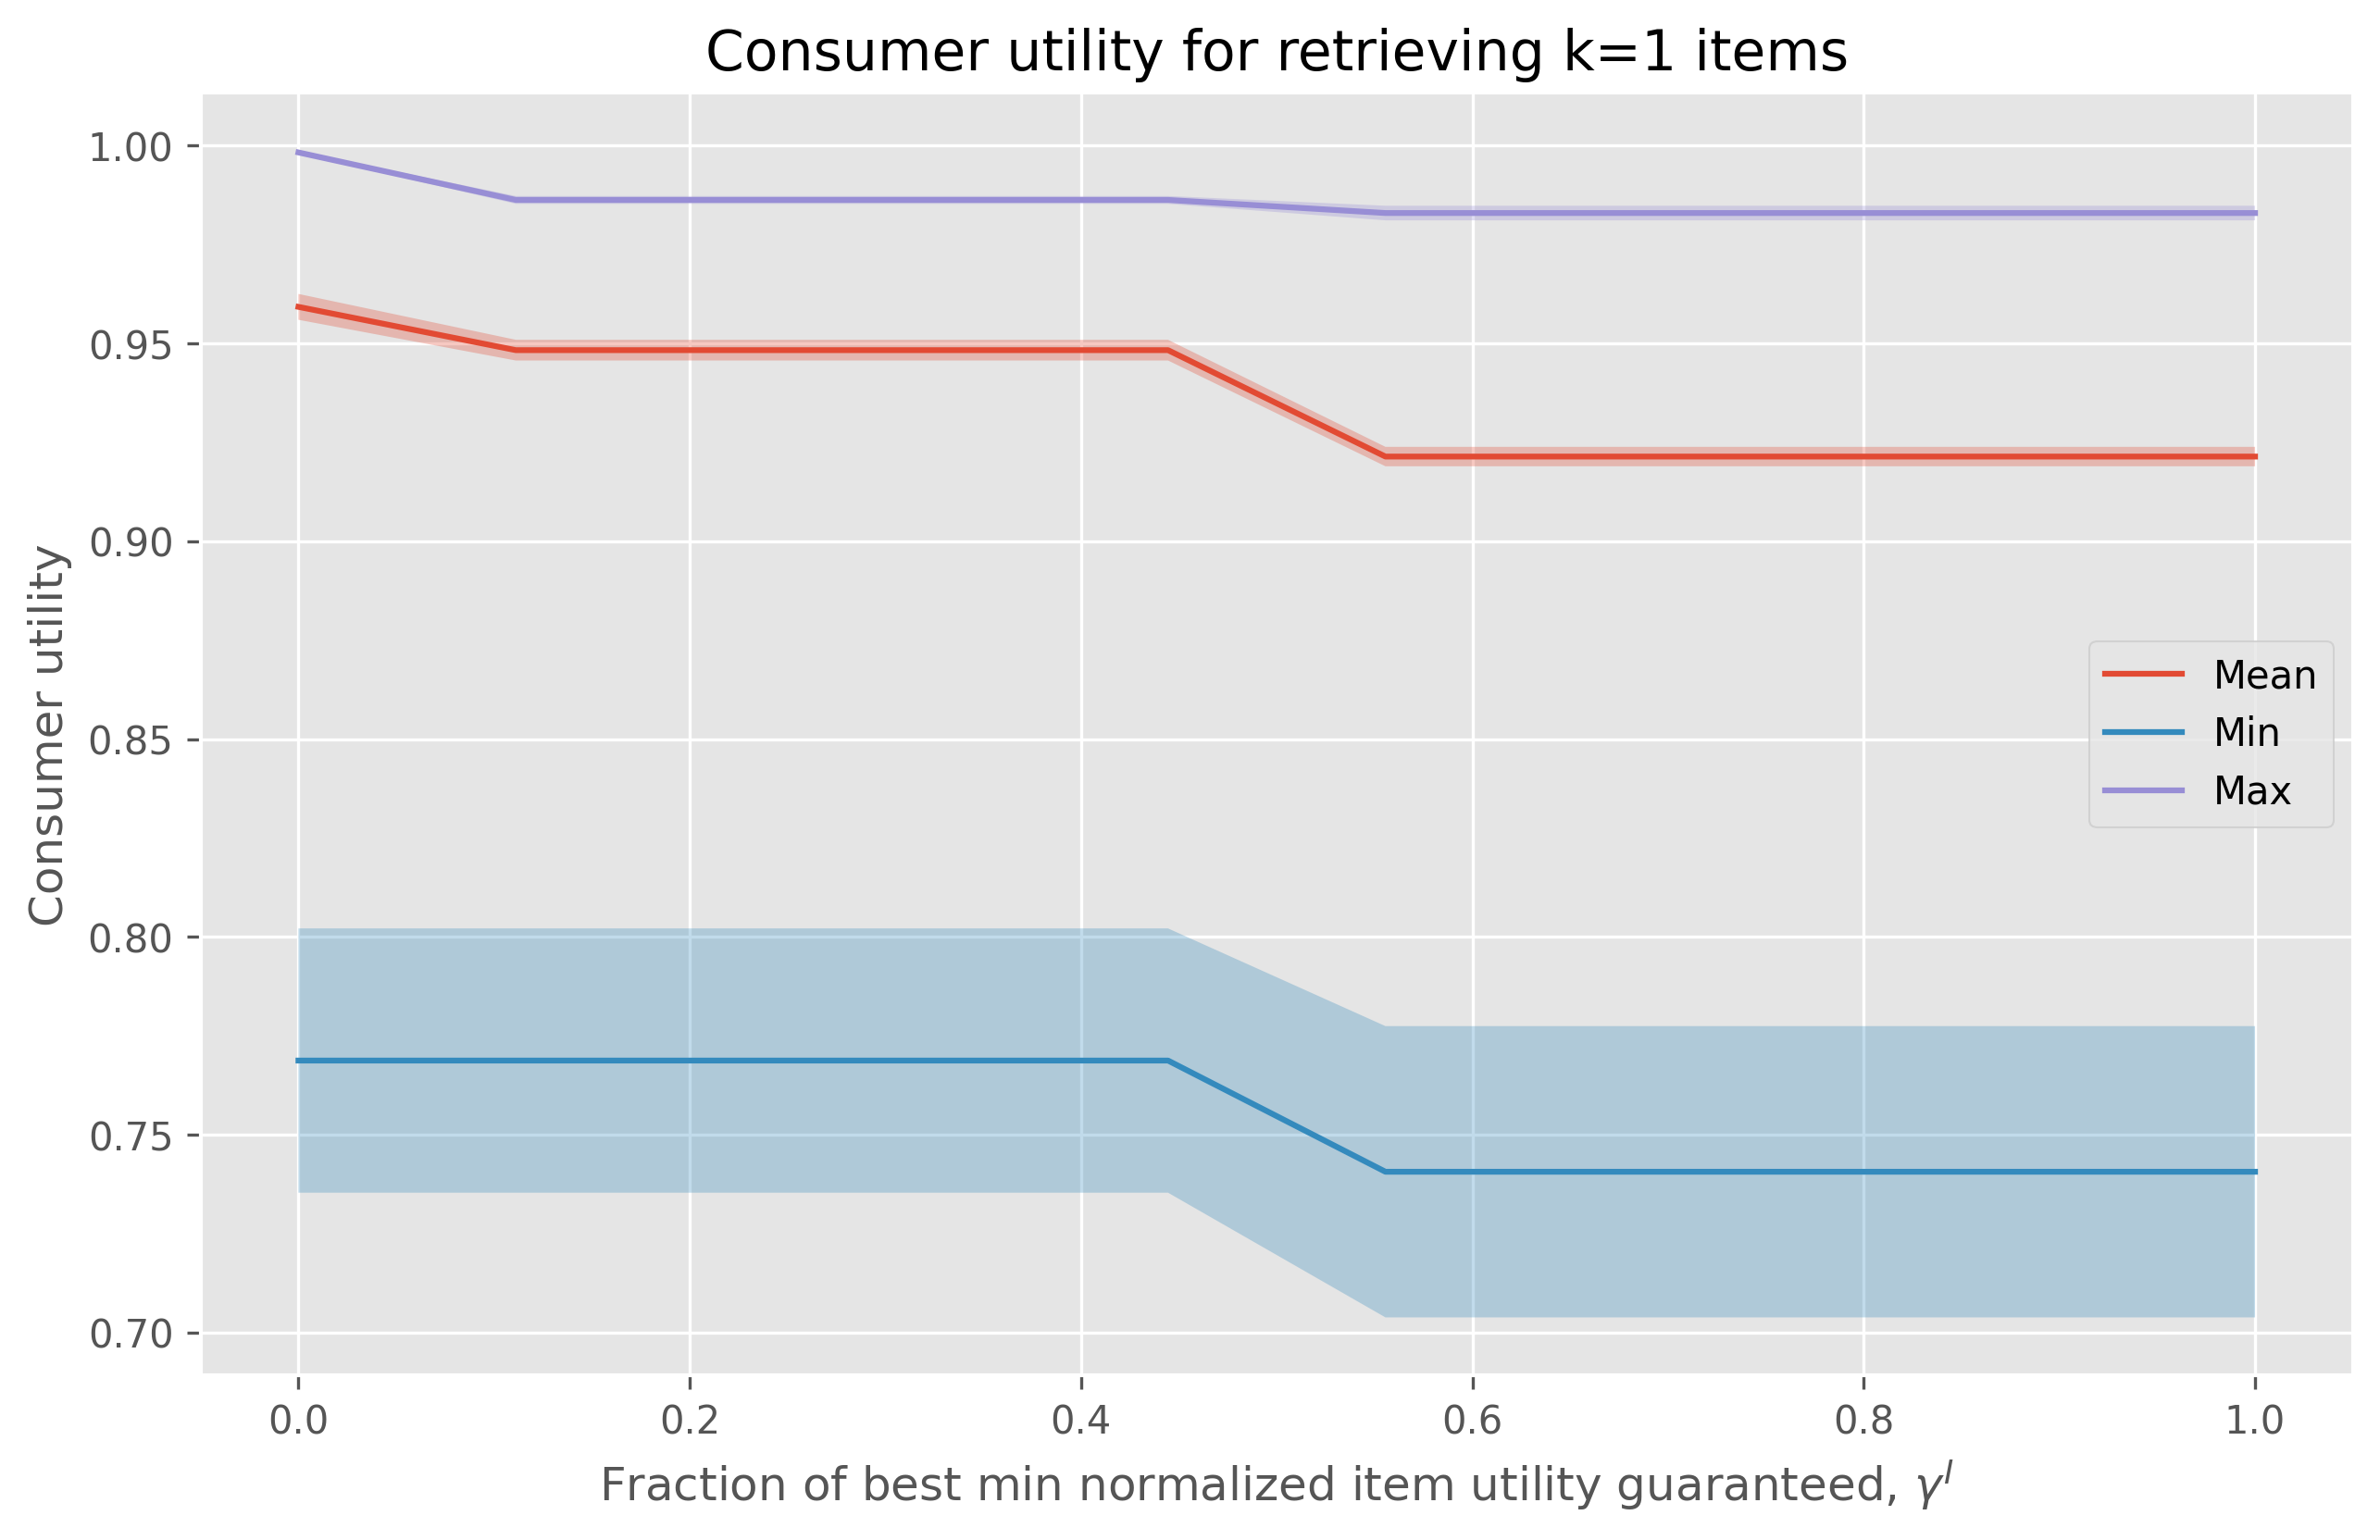

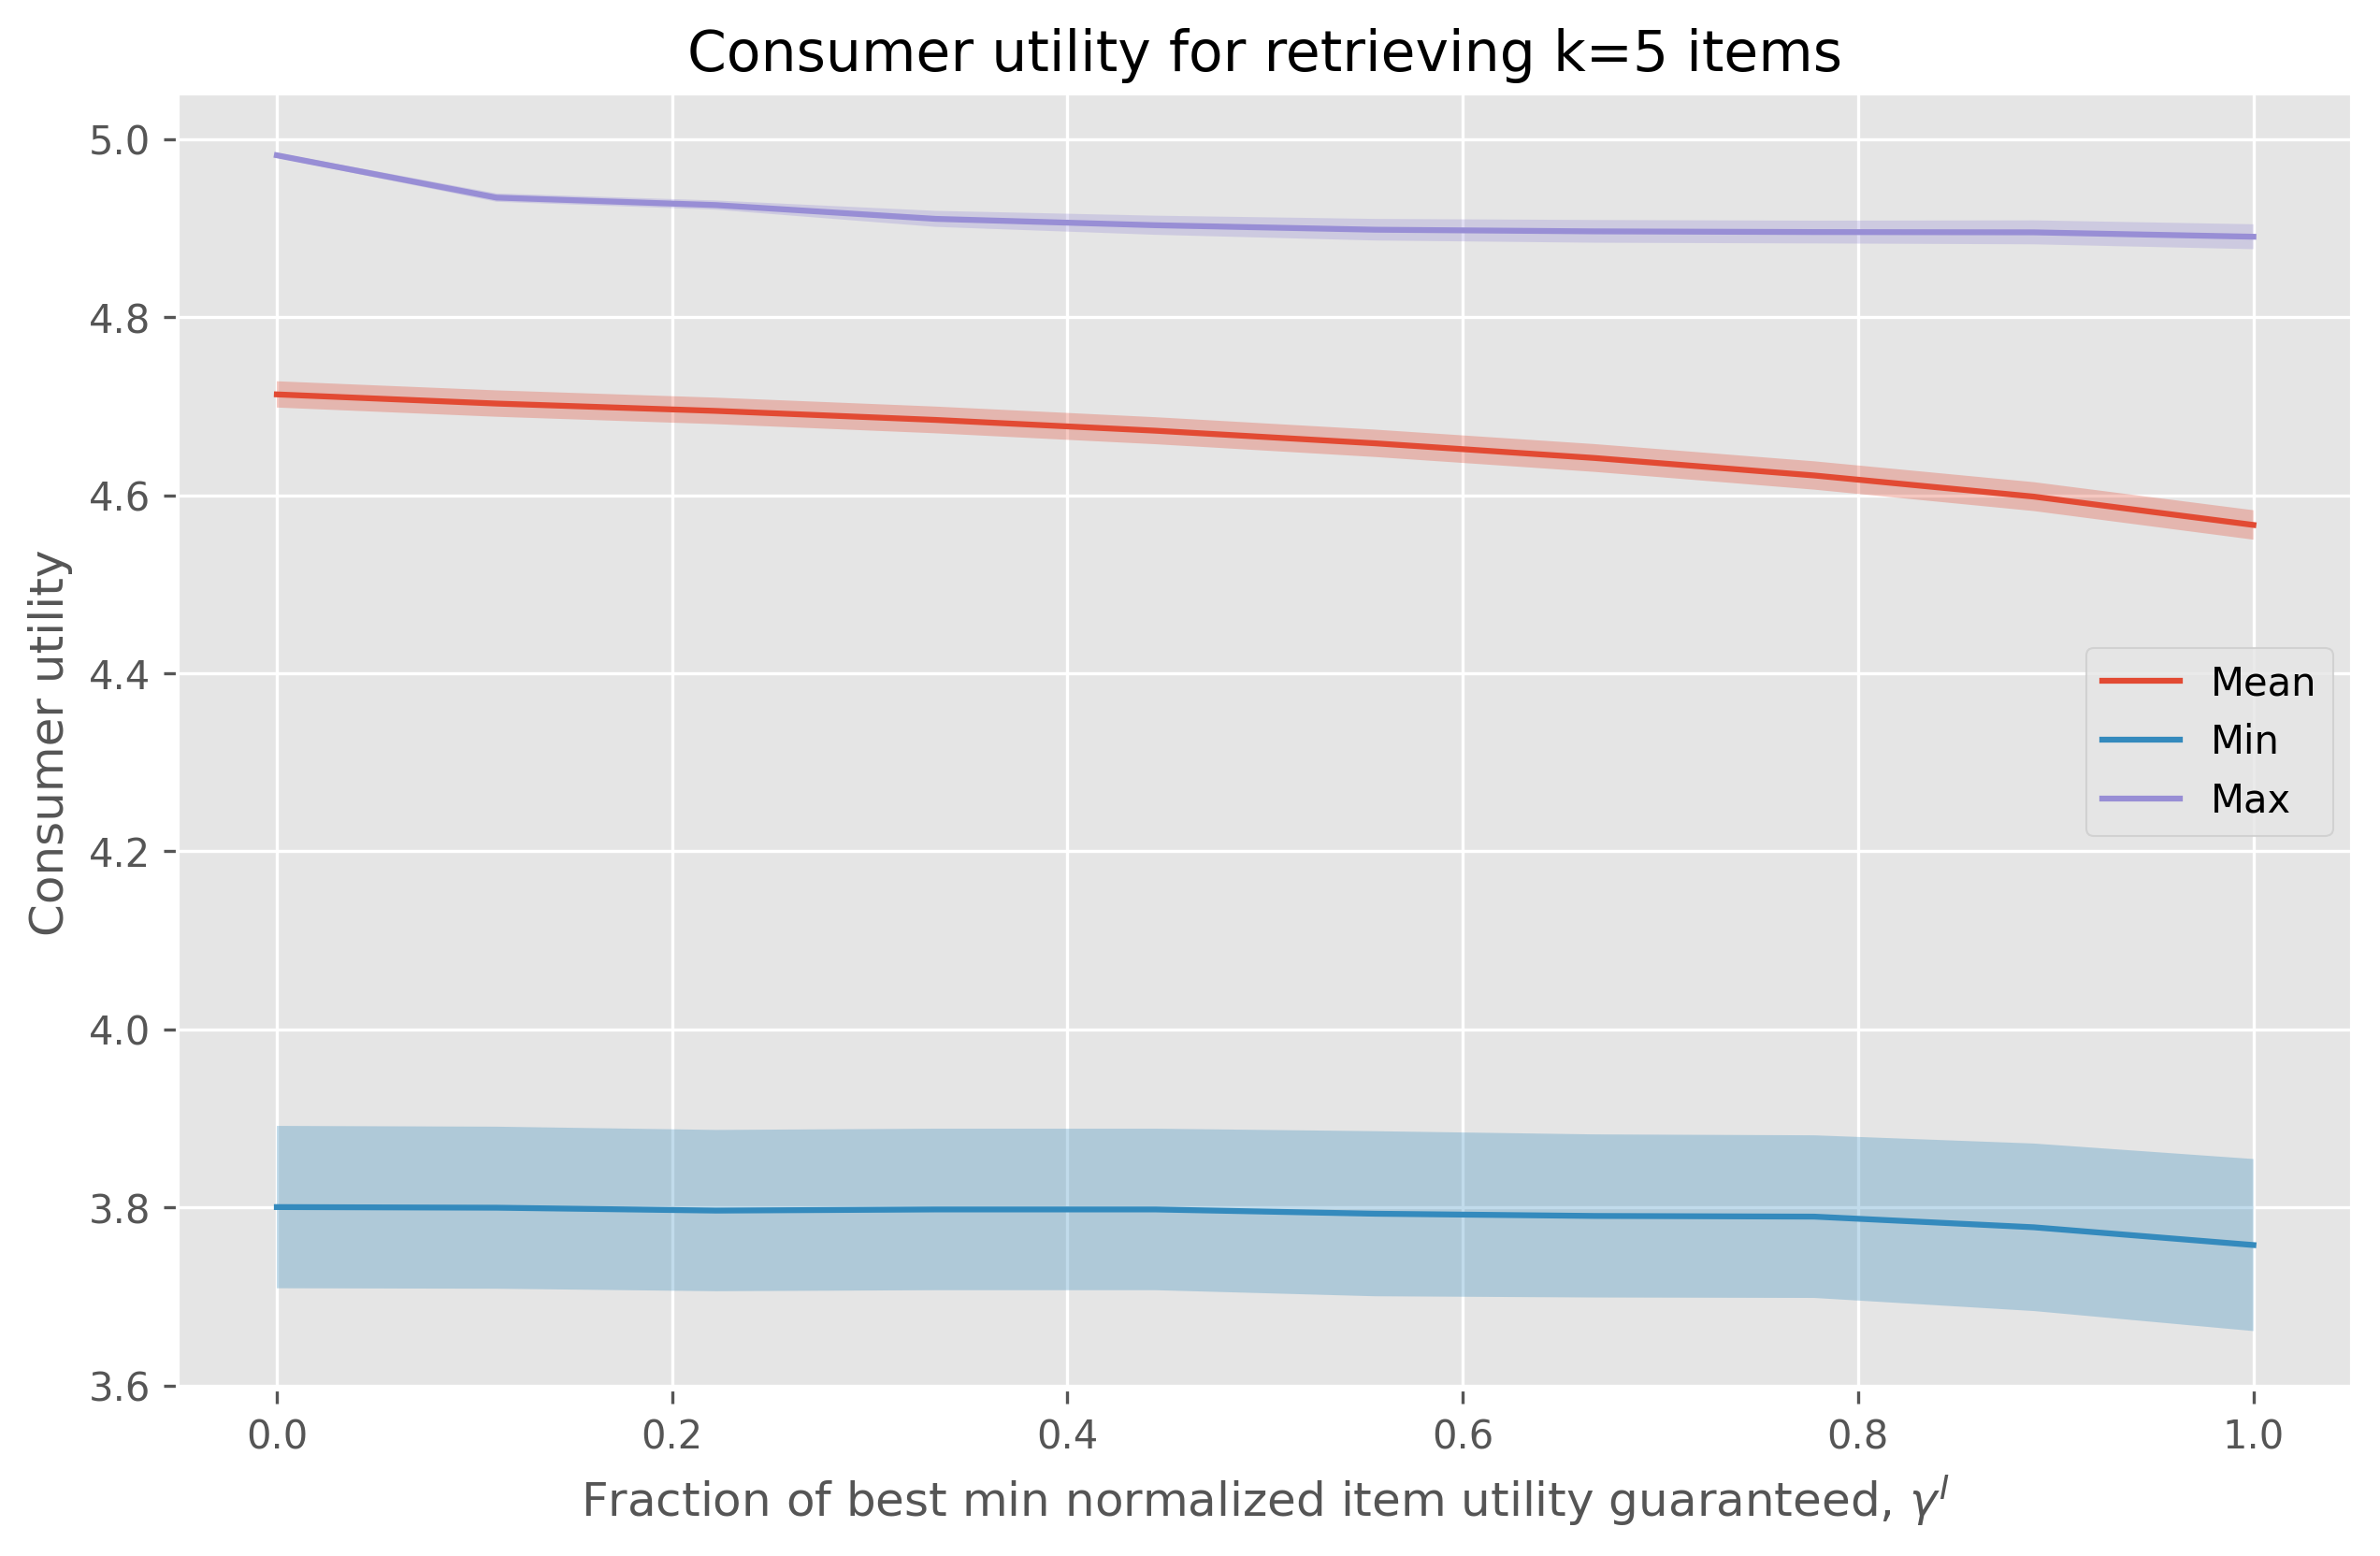

In [10]:
user_size = 100
items_size = 50
top_k = 1
n_runs = 10
gamma_points = np.linspace(0, 1, 10)
group_name = "usage_group"
all_empirical_pairs, users_ids, u_utils, _ = get_curves_user_default(u_rel_matrx, user_size, items_size, n_runs, gamma_points, top_k, user_groups, group_name)

mean_u_utils = [[np.mean(gamma) for gamma in run] for run in u_utils]
min_u_utils = [[np.min(gamma) for gamma in run] for run in u_utils]
max_u_utils = [[np.max(gamma) for gamma in run] for run in u_utils]

plt.figure(figsize=(10, 6), dpi=300)
plt.title("Consumer utility for retrieving k=1 items")
plt.plot(gamma_points, np.mean(mean_u_utils, axis=0), label="Mean")
standard_err = np.std(mean_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(mean_u_utils, axis=0) - standard_err, np.mean(mean_u_utils, axis=0) + standard_err, alpha=0.3)
plt.plot(gamma_points, np.mean(min_u_utils, axis=0), label="Min")
standard_err = np.std(min_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(min_u_utils, axis=0) - standard_err, np.mean(min_u_utils, axis=0) + standard_err, alpha=0.3)
plt.plot(gamma_points, np.mean(max_u_utils, axis=0), label="Max")
standard_err = np.std(max_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(max_u_utils, axis=0) - standard_err, np.mean(max_u_utils, axis=0) + standard_err, alpha=0.3)
plt.ylabel('Consumer utility')
plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
plt.legend()
plt.savefig("./media11/consumer_utility_k1.png")


user_size = 100
items_size = 50
top_k = 5
n_runs = 10
gamma_points = np.linspace(0, 1, 10)
group_name = "usage_group"
all_empirical_pairs, users_ids, u_utils, _ = get_curves_user_default(u_rel_matrx, user_size, items_size, n_runs, gamma_points, top_k, user_groups, group_name)

mean_u_utils = [[np.mean(gamma) for gamma in run] for run in u_utils]
min_u_utils = [[np.min(gamma) for gamma in run] for run in u_utils]
max_u_utils = [[np.max(gamma) for gamma in run] for run in u_utils]

plt.figure(figsize=(10, 6), dpi=300)
plt.title("Consumer utility for retrieving k=5 items")
plt.plot(gamma_points, np.mean(mean_u_utils, axis=0), label="Mean")
standard_err = np.std(mean_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(mean_u_utils, axis=0) - standard_err, np.mean(mean_u_utils, axis=0) + standard_err, alpha=0.3)
plt.plot(gamma_points, np.mean(min_u_utils, axis=0), label="Min")
standard_err = np.std(min_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(min_u_utils, axis=0) - standard_err, np.mean(min_u_utils, axis=0) + standard_err, alpha=0.3)
plt.plot(gamma_points, np.mean(max_u_utils, axis=0), label="Max")
standard_err = np.std(max_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(max_u_utils, axis=0) - standard_err, np.mean(max_u_utils, axis=0) + standard_err, alpha=0.3)
plt.ylabel('Consumer utility')
plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
plt.legend()
plt.savefig("./media11/consumer_utility_k5.png")

100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


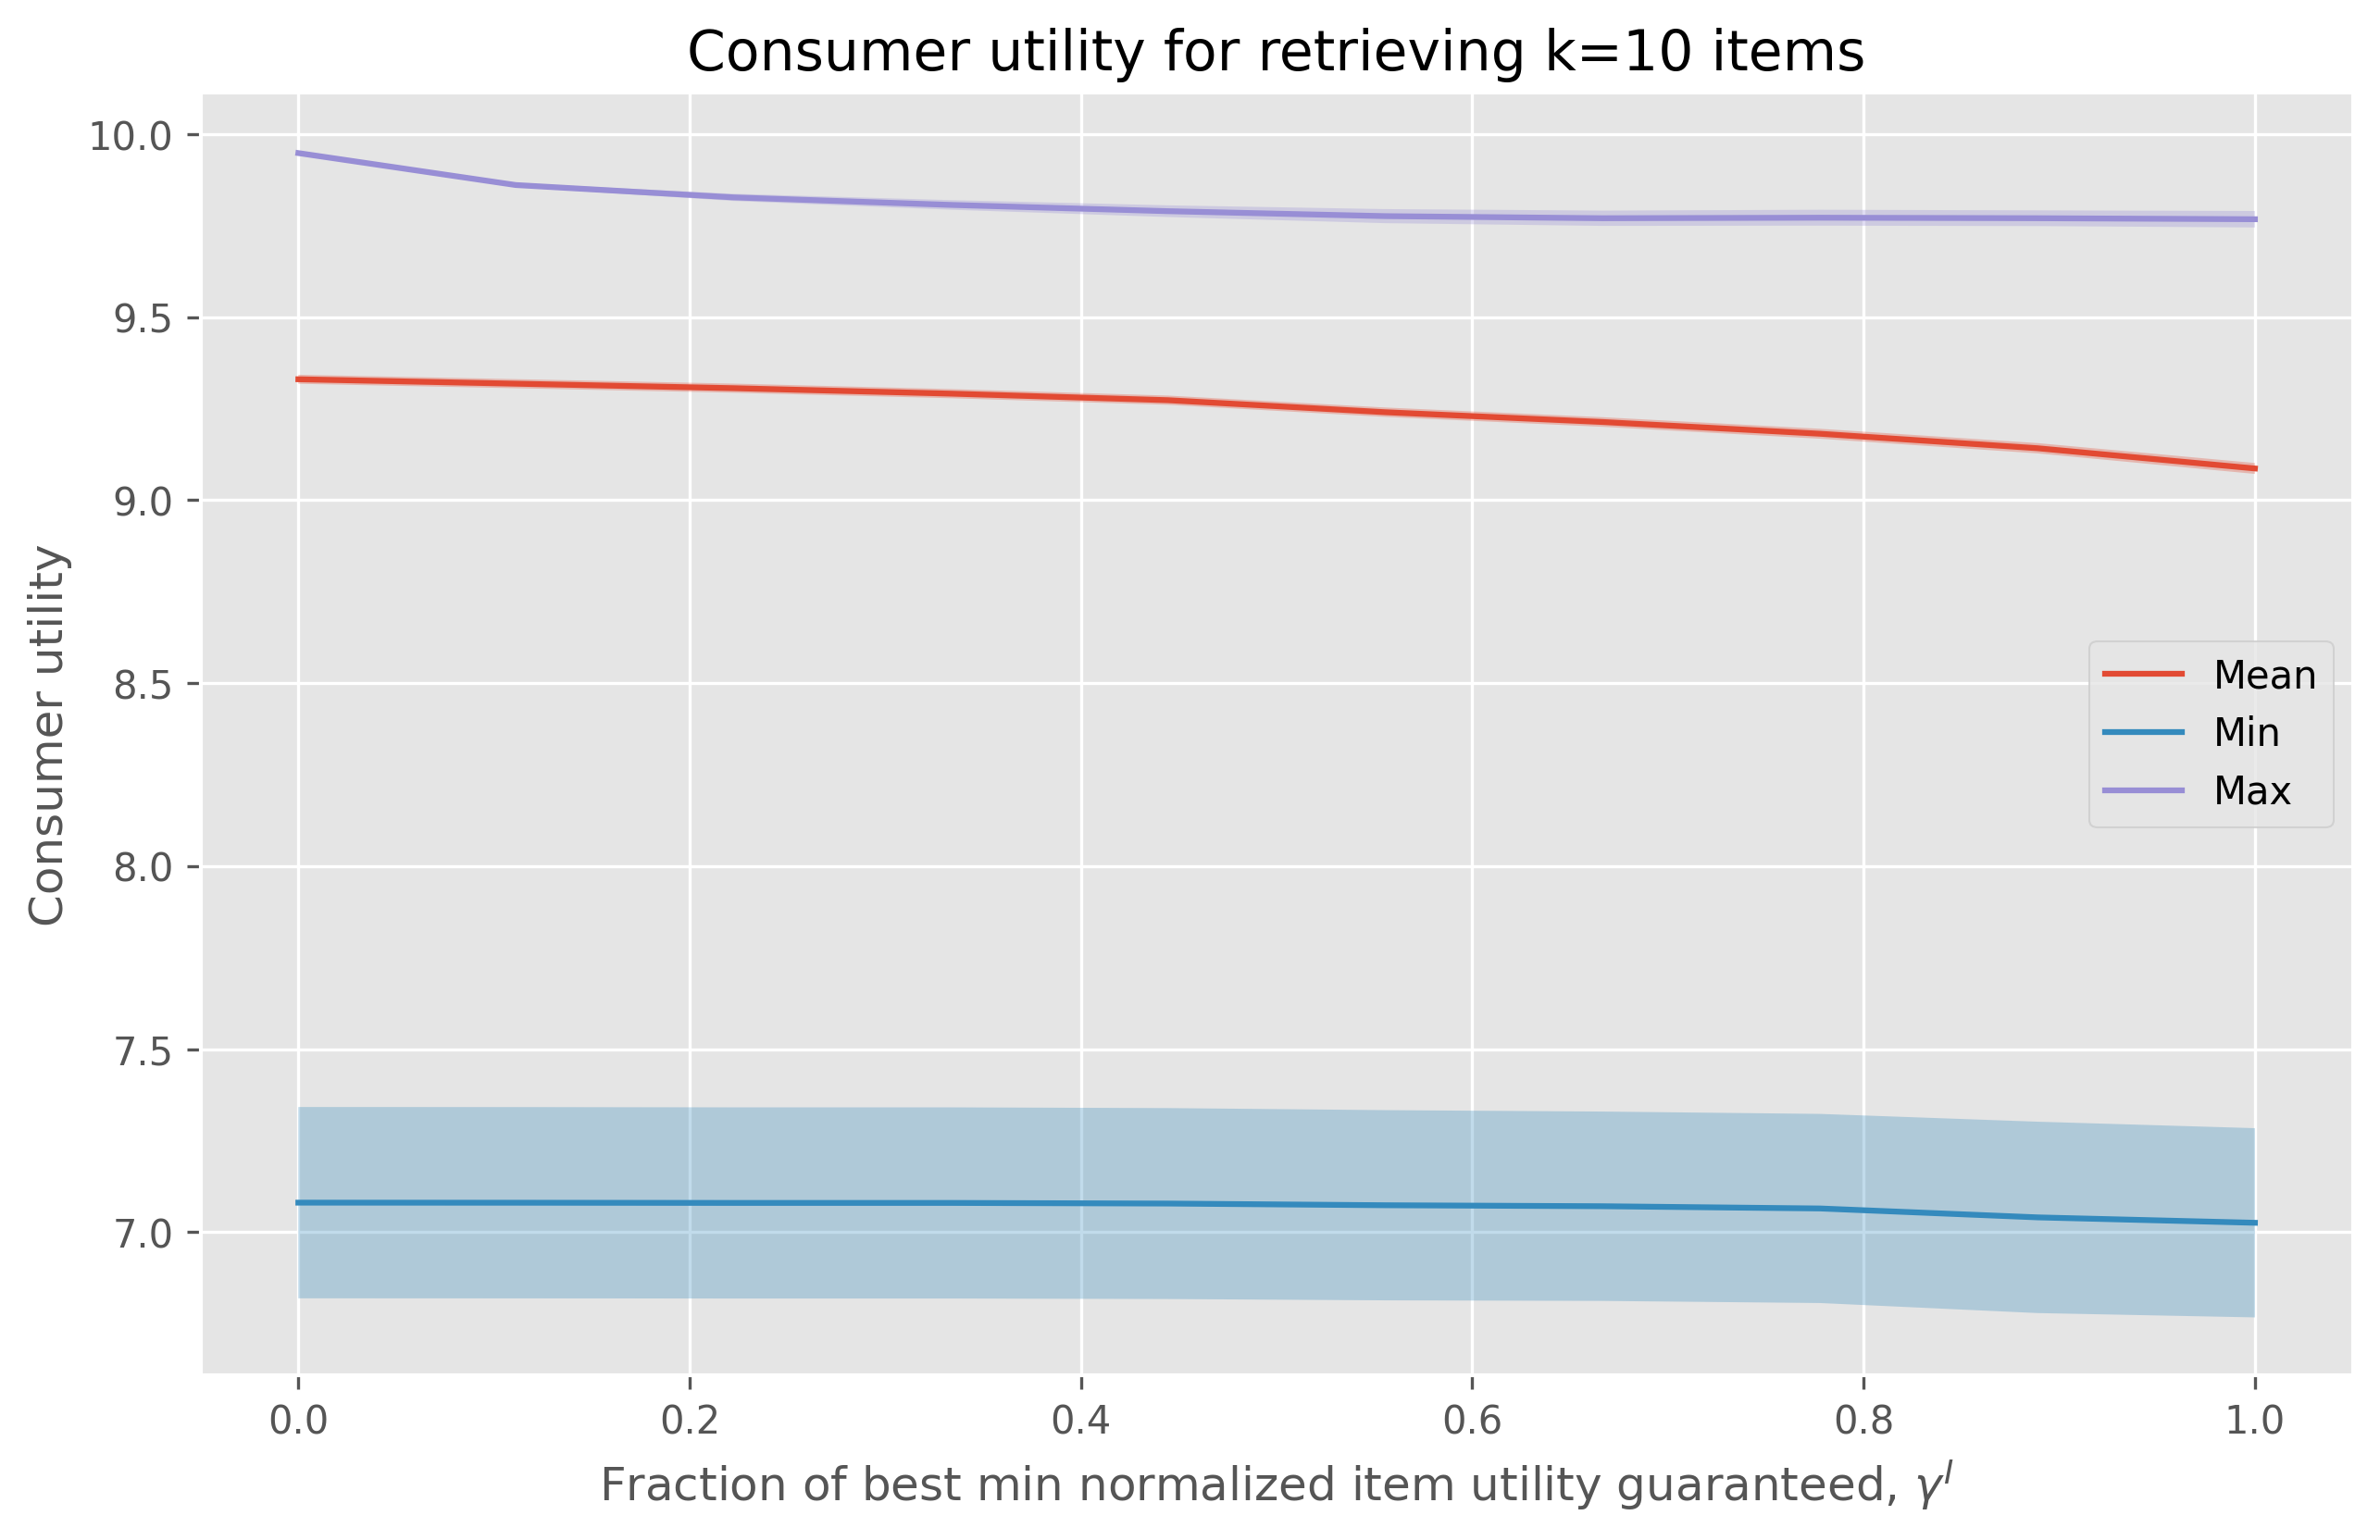

In [11]:
user_size = 100
items_size = 50
top_k = 10
n_runs = 10
gamma_points = np.linspace(0, 1, 10)
group_name = "usage_group"
all_empirical_pairs, users_ids, u_utils, _ = get_curves_user_default(u_rel_matrx, user_size, items_size, n_runs, gamma_points, top_k, user_groups, group_name)

mean_u_utils = [[np.mean(gamma) for gamma in run] for run in u_utils]
min_u_utils = [[np.min(gamma) for gamma in run] for run in u_utils]
max_u_utils = [[np.max(gamma) for gamma in run] for run in u_utils]

plt.figure(figsize=(10, 6), dpi=300)
plt.title("Consumer utility for retrieving k=10 items")
plt.plot(gamma_points, np.mean(mean_u_utils, axis=0), label="Mean")
standard_err = np.std(mean_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(mean_u_utils, axis=0) - standard_err, np.mean(mean_u_utils, axis=0) + standard_err, alpha=0.3)
plt.plot(gamma_points, np.mean(min_u_utils, axis=0), label="Min")
standard_err = np.std(min_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(min_u_utils, axis=0) - standard_err, np.mean(min_u_utils, axis=0) + standard_err, alpha=0.3)
plt.plot(gamma_points, np.mean(max_u_utils, axis=0), label="Max")
standard_err = np.std(max_u_utils, axis=0) / np.sqrt(n_runs)
plt.fill_between(gamma_points, np.mean(max_u_utils, axis=0) - standard_err, np.mean(max_u_utils, axis=0) + standard_err, alpha=0.3)
plt.ylabel('Consumer utility')
plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
plt.legend()
plt.savefig("./media11/consumer_utility_k10.png")

In [15]:
results

defaultdict(<function __main__.<lambda>()>,
            {'automotive': defaultdict(list,
                         {np.float64(0.0): [np.float64(nan),
                           np.float64(nan),
                           np.float64(nan),
                           np.float64(nan),
                           np.float64(nan)],
                          np.float64(0.35): [np.float64(nan),
                           np.float64(nan),
                           np.float64(nan),
                           np.float64(nan),
                           np.float64(nan)],
                          np.float64(0.7): [np.float64(nan),
                           np.float64(nan),
                           np.float64(nan),
                           np.float64(nan),
                           np.float64(nan)],
                          np.float64(1.0): [np.float64(nan),
                           np.float64(nan),
                           np.float64(nan),
                           np.float64(nan),
   

 40%|████      | 2/5 [02:47<04:11, 83.82s/it]/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_86658/3281966231.py:108: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10), dpi=300)
100%|██████████| 5/5 [07:12<00:00, 86.48s/it]


<Figure size 3000x3000 with 0 Axes>

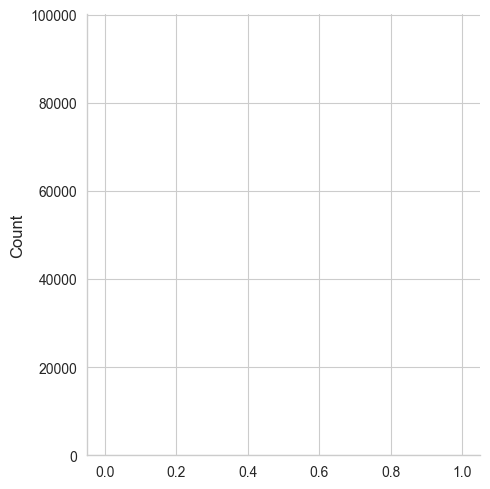

<Figure size 3000x3000 with 0 Axes>

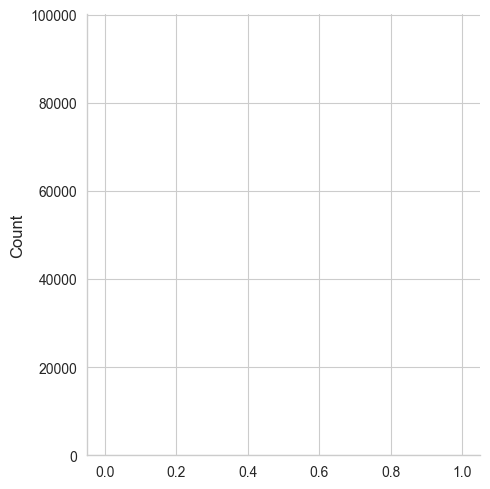

<Figure size 3000x3000 with 0 Axes>

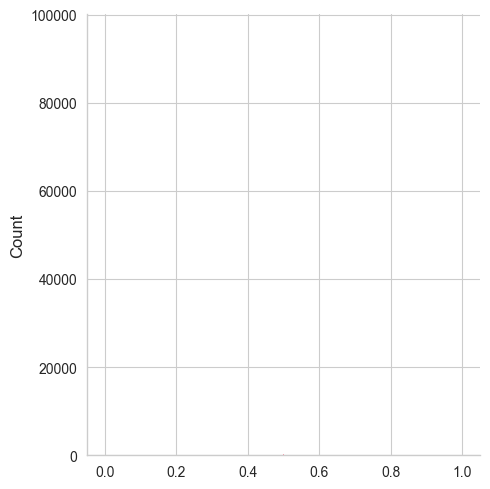

<Figure size 3000x3000 with 0 Axes>

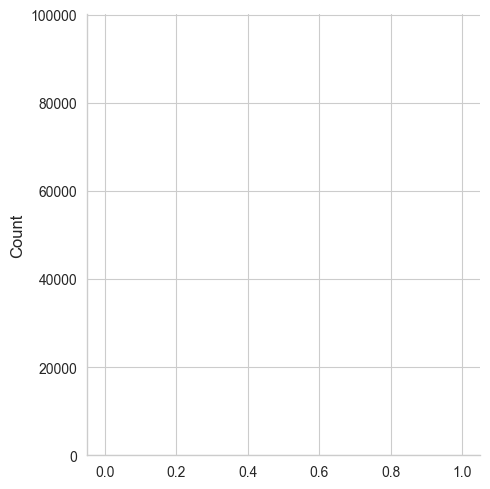

<Figure size 3000x3000 with 0 Axes>

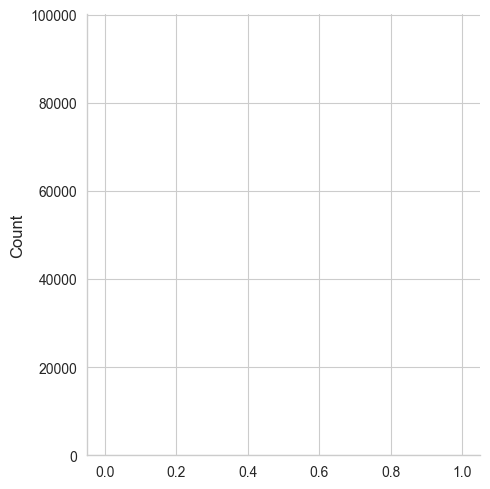

<Figure size 3000x3000 with 0 Axes>

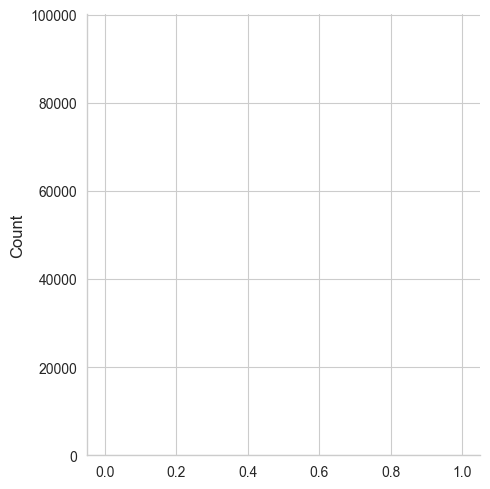

<Figure size 3000x3000 with 0 Axes>

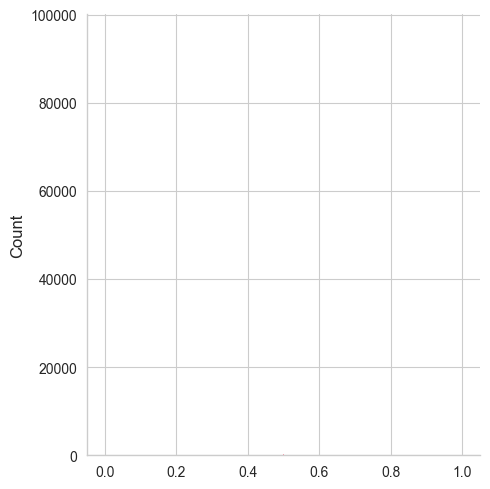

<Figure size 3000x3000 with 0 Axes>

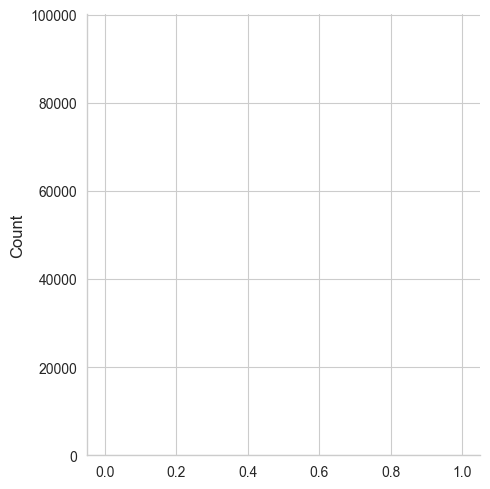

<Figure size 3000x3000 with 0 Axes>

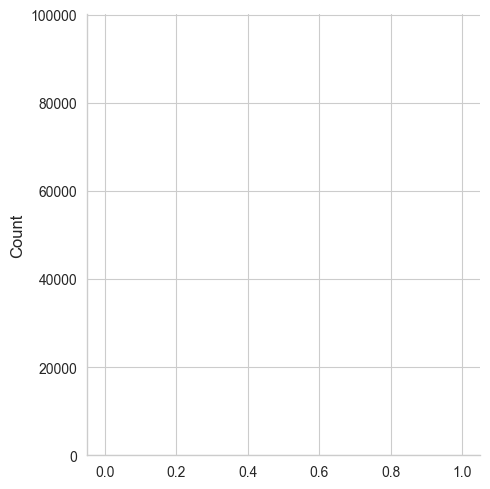

<Figure size 3000x3000 with 0 Axes>

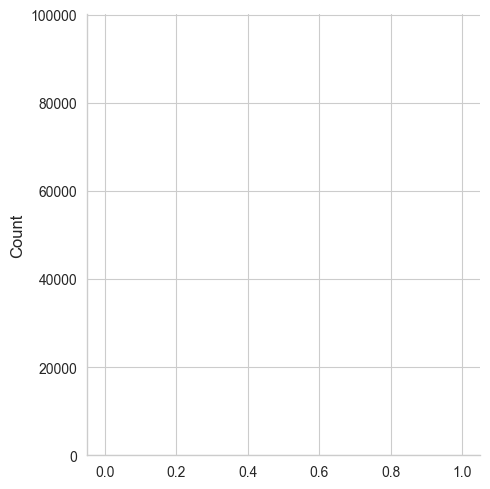

<Figure size 3000x3000 with 0 Axes>

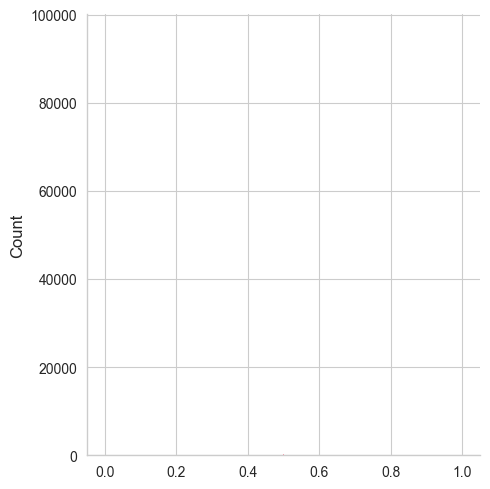

<Figure size 3000x3000 with 0 Axes>

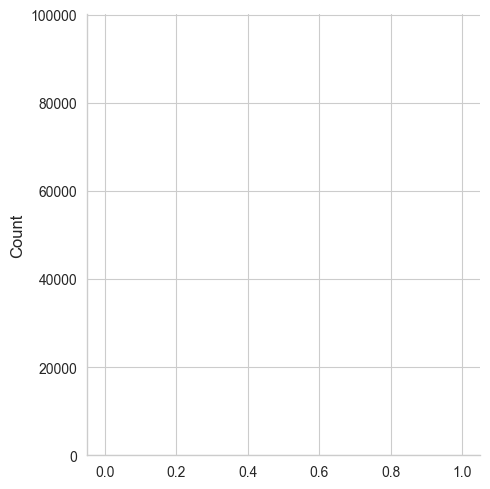

<Figure size 3000x3000 with 0 Axes>

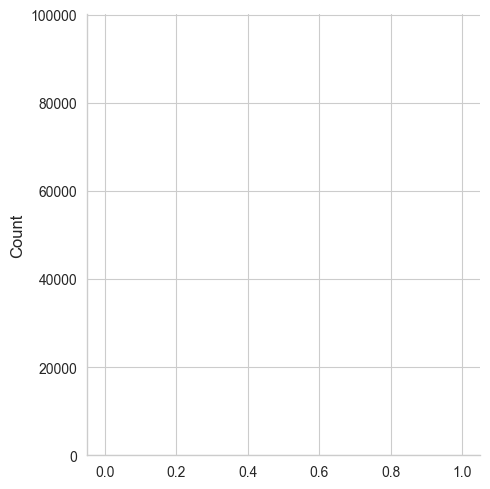

<Figure size 3000x3000 with 0 Axes>

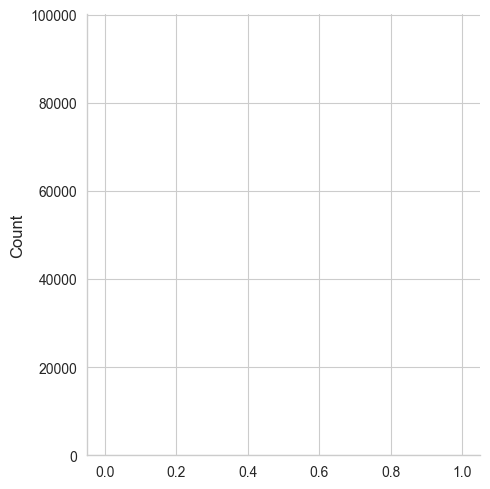

<Figure size 3000x3000 with 0 Axes>

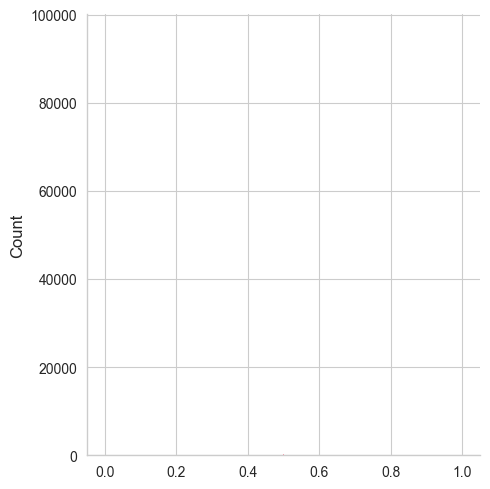

<Figure size 3000x3000 with 0 Axes>

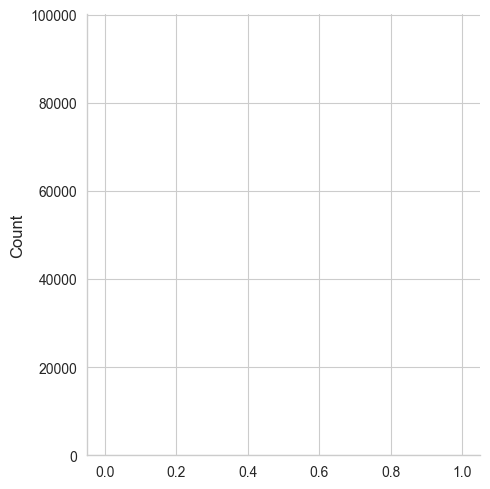

<Figure size 3000x3000 with 0 Axes>

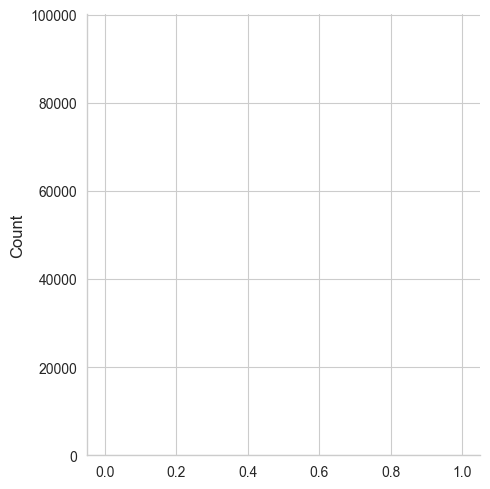

<Figure size 3000x3000 with 0 Axes>

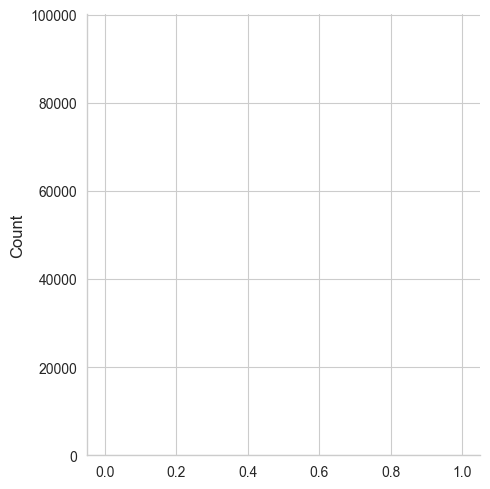

<Figure size 3000x3000 with 0 Axes>

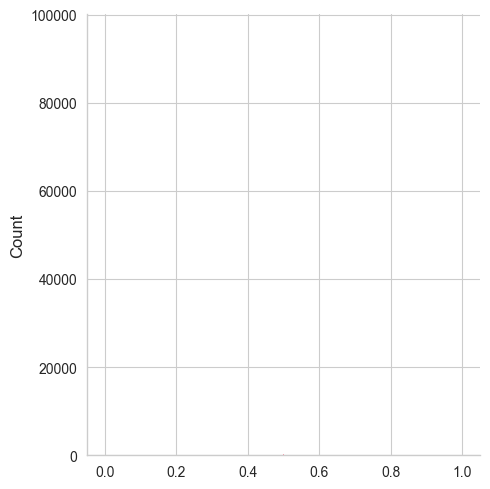

<Figure size 3000x3000 with 0 Axes>

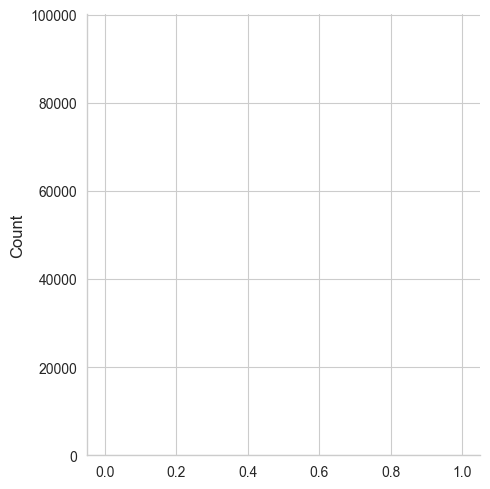

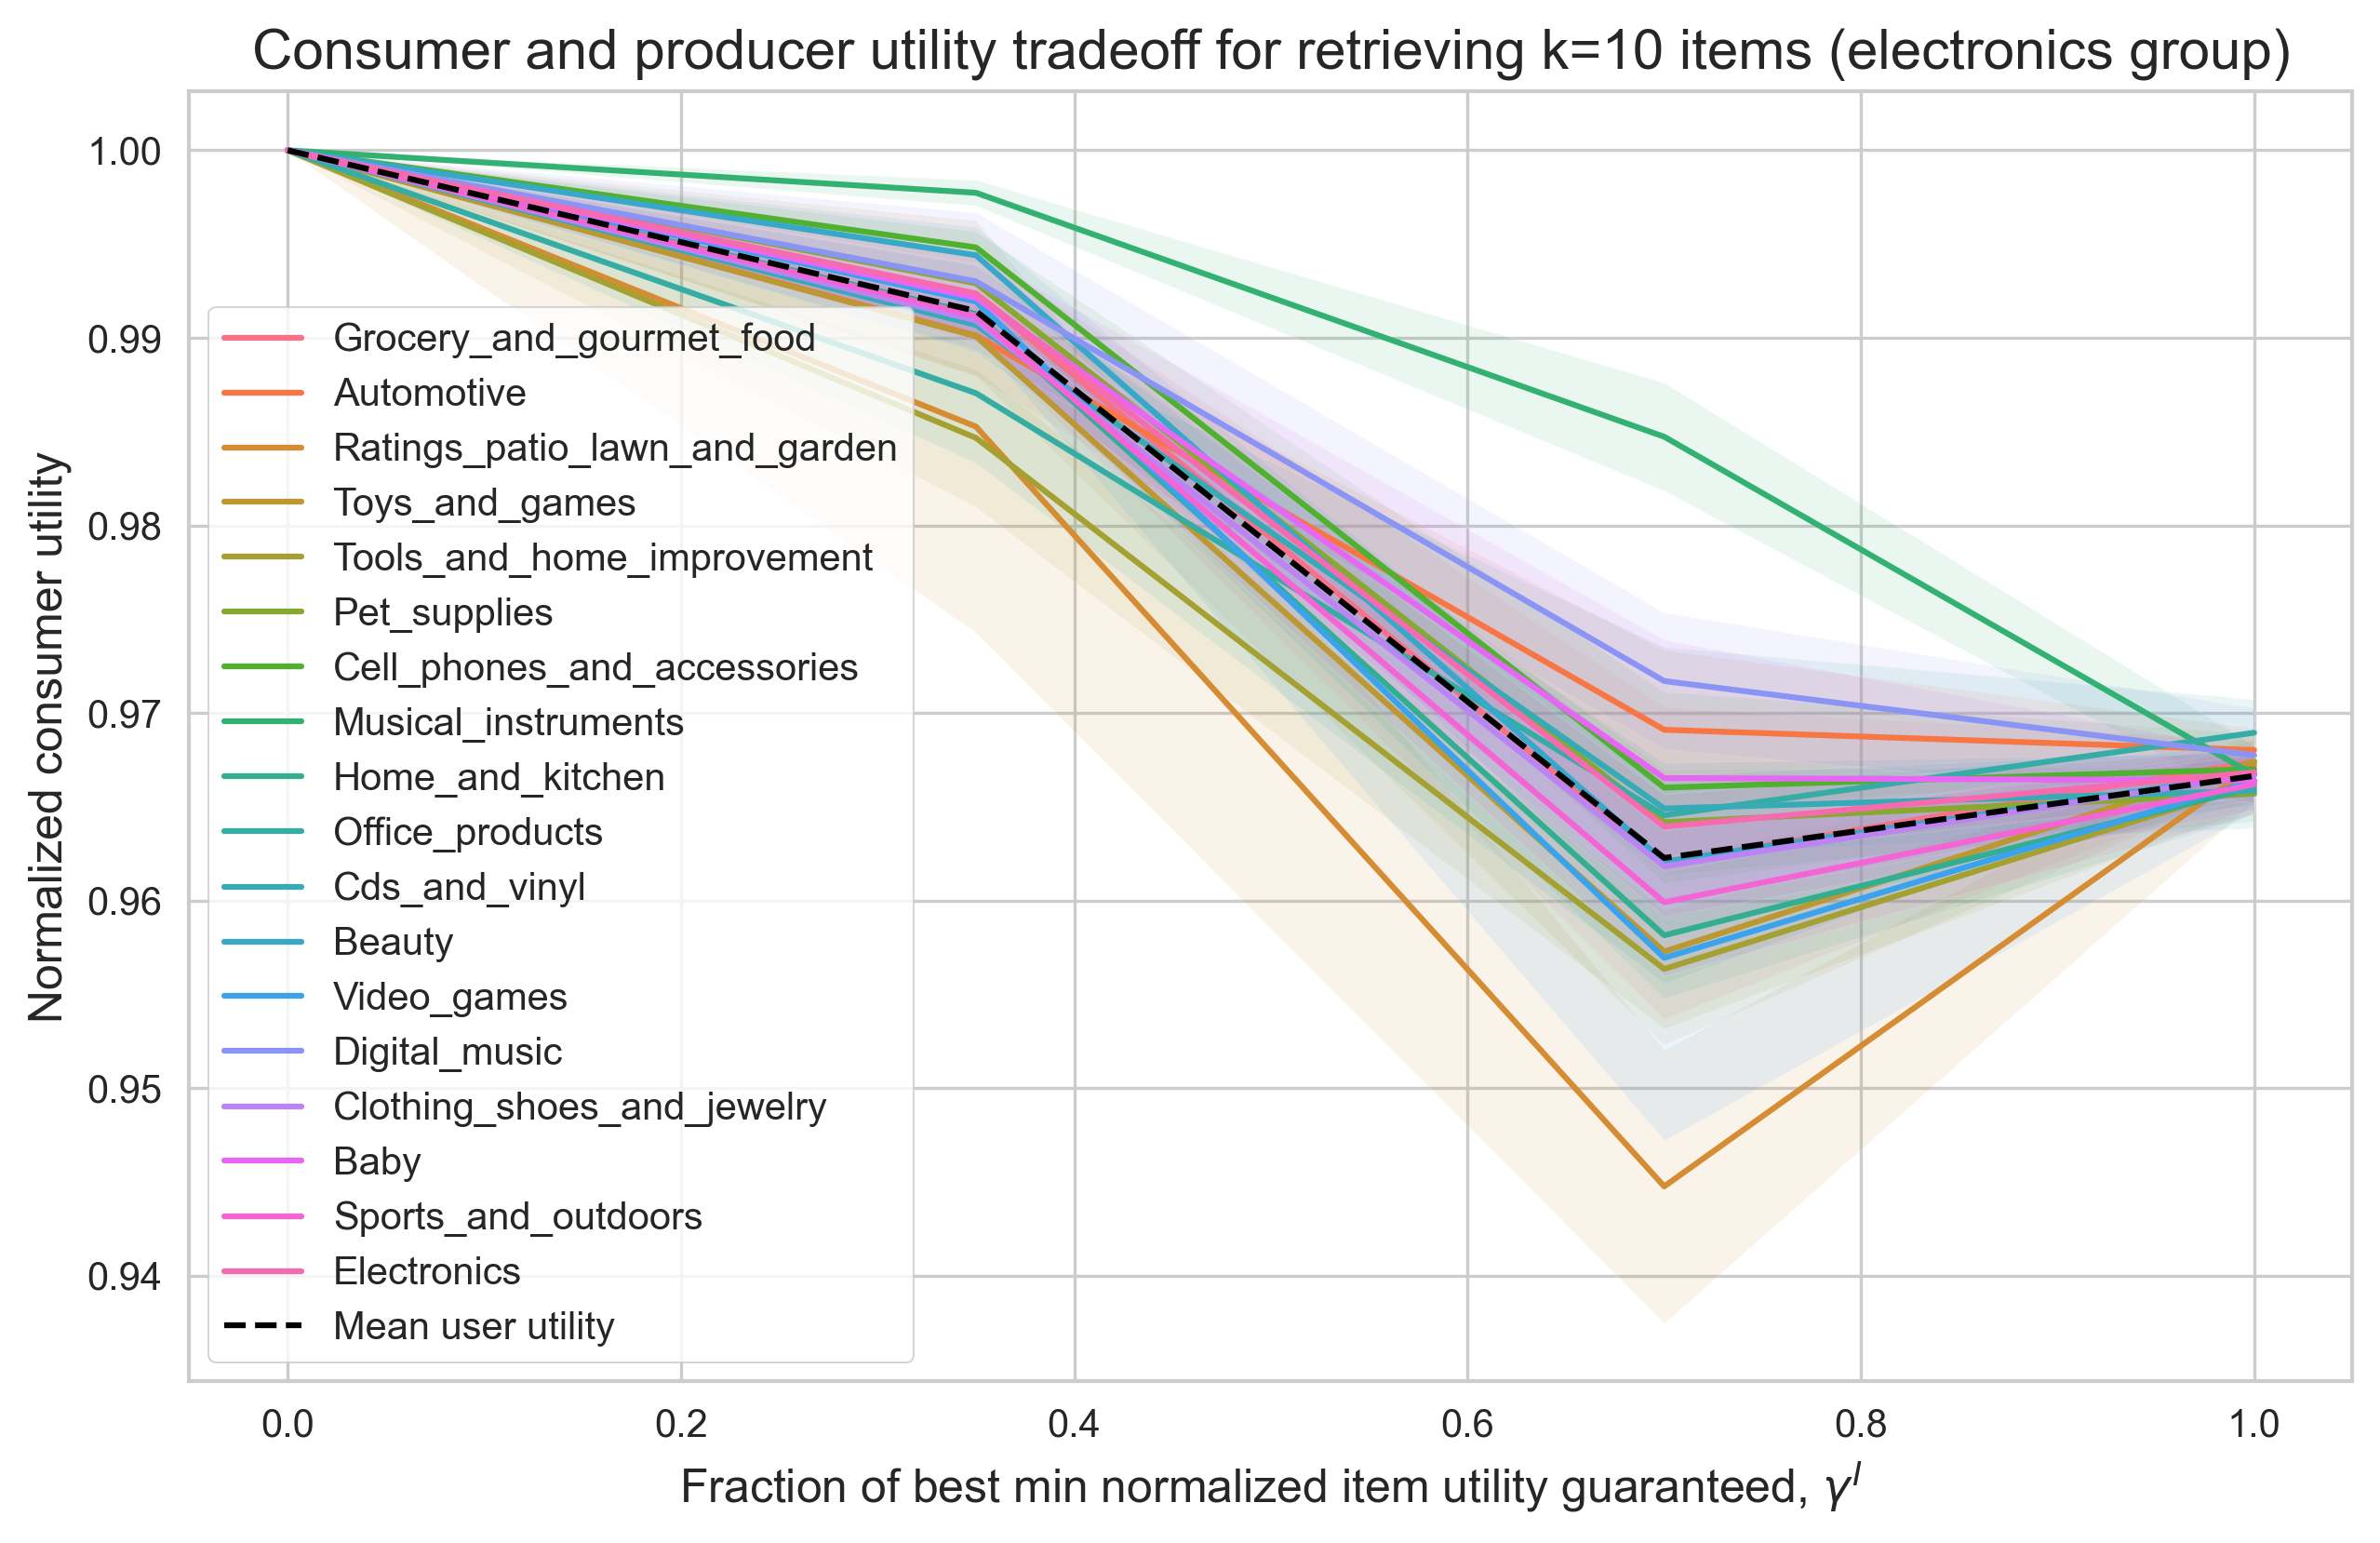

In [36]:
import seaborn as sns

sns.set_style("whitegrid")

for group_name in ["top_category"]:
    group_names = sorted({i[group_name] for i in user_groups})
    gamma_points = [0, 0.35, 0.7, 1]
    colors = sns.color_palette("husl", len(group_names))
    n_runs = 5
    user_size = 500
    items_size = 200
    top_k = 10

    all_empirical_pairs, users_ids, u_utils = get_curves_user_groups(u_rel_matrx, user_size, items_size, n_runs, gamma_points, top_k, user_groups, group_name)

    results = defaultdict(dict)
    gammas = all_empirical_pairs[0,:,0]

    groups = [row[group_name] for row in user_groups if row["user_id"] in users_ids[0]]


    results = defaultdict(lambda: defaultdict(list))

    for group in set(groups):
        for gamma_id, gamma in enumerate([0, 0.35, 0.7, 1]):
            for run_id in range(n_runs):
                run_user_ids = users_ids[run_id]
                run_user_groups = np.array([i[group_name] for i in user_groups if i["user_id"] in run_user_ids])
                run_user_groups_idx = np.where(run_user_groups == group)[0]
                run_user_utils = u_utils[run_id]
                results[group][gamma].append(run_user_utils[gamma_id][run_user_groups_idx].mean())

    plt.figure(figsize=(10,6), dpi=300)
    sns.set_palette(colors)
    # sort results by group name
    for group in results.items():
        group_name, _gammas = group
        gamma_means = {}
        gamma_std_err = {}
        for gamma, runs in _gammas.items():
            gamma_means[gamma] = np.mean(runs)
            gamma_std_err[gamma] = np.std(runs) / np.sqrt(n_runs)


        plt.plot(
            list(gamma_means.keys()),
            list(gamma_means.values()),
            label=f"{group_name.capitalize()}",
        )
        plt.fill_between(
            list(gamma_std_err.keys()),
            np.array(list(gamma_means.values())) - np.array(list(gamma_std_err.values())),
            np.array(list(gamma_means.values())) + np.array(list(gamma_std_err.values())),
            alpha=0.1,
        )

    plt.ylabel('Normalized consumer utility')
    plt.title(f"Consumer and producer utility tradeoff for retrieving k=10 items ({group_name.replace("group", "").replace('_', ' ')} group)")
    plt.xlabel(r'Fraction of best min normalized item utility guaranteed, $\gamma^I$')
    plt.plot(gammas, np.mean(u_utils, axis=2).mean(axis=0), color="black", label="Mean user utility", linestyle="--")
    plt.legend()
    plt.savefig(f"./media22/tradeoff_curve_group_{group_name}_user_size_{user_size}_items_{items_size}_n_draws_{n_runs}_top_k_{top_k}.png")

In [76]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


def display_group_boxplots(type, user_ids, user_utils, user_groups, gammas, group_name, top_k, output_path):
    n_runs = len(user_ids)
    users_size = len(user_ids[0])
    items_size = len(user_utils[0][0])

    results = defaultdict(dict)

    groups = [row[group_name] for row in user_groups if row["user_id"] in users_ids[0]]

    results = defaultdict(lambda: defaultdict(list))

    for gamma_id, gamma in enumerate(gammas):
        for group in set(groups):
            for run_id in range(n_runs):
                run_user_ids = users_ids[run_id]
                run_user_groups = np.array([i[group_name] for i in user_groups if i["user_id"] in run_user_ids])
                run_user_groups_idx = np.where(run_user_groups == group)[0]
                run_user_utils = user_utils[run_id]
                results[gamma][group].extend(run_user_utils[gamma_id][run_user_groups_idx])

    all_groups = sorted(set(k for gamma in results.values() for k in gamma))
    colors = sns.color_palette("rocket", len(all_groups))
    color_map = dict(zip(all_groups, colors))

    plt.figure(figsize=(10, 10), dpi=300)
    # Plot each gamma
    for gamma_id, (gamma, _groups) in enumerate(results.items()):
        _ = plt.subplot(2, 2, gamma_id + 1)
        plt.title(f"$\gamma$ = {gamma}", fontdict={"fontsize": 12})

        # Sort groups for consistent order and plot
        _groups = {k: _groups[k] for k in sorted(_groups.keys())}
        box_plot_data = list(_groups.values())
        box = plt.boxplot(
            box_plot_data,
            labels=list(_groups.keys()),
            showfliers=False,
            patch_artist=True,
            medianprops=dict(color='black'),  # Add black median line
        )

        # Apply consistent colors
        for patch, label in zip(box['boxes'], _groups.keys()):
            patch.set_facecolor(color_map[label])


    # Adjust subplot parameters to give space for axis labels
    plt.subplots_adjust(left=0.12, bottom=0.11)

    # Set unified axis labels for the entire figure
    plt.figtext(0.5, 0.05, "Group", ha="center", fontsize=12)
    plt.figtext(0.03, 0.5, "Normalized consumer utility", va="center", rotation="vertical", fontsize=12)

    # Create legend
    legend_handles = [mpatches.Patch(color=color_map[group], label=group.capitalize()) for group in all_groups]
    plt.figlegend(handles=legend_handles, loc='upper right', title='Groups')
    # add global title
    plt.suptitle(f"Consumer utility distribution for retrieving k=10 items ({group_name.replace('group', '').replace('_', ' ')} group)", fontsize=16)

    output_path = output_path + f"{type}_consumer_utility_boxplots_{group_name}_user_size_{users_size}_items_{items_size}_n_draws_{n_runs}_top_k_{top_k}.pdf"

    plt.savefig(output_path)


<>:34: SyntaxWarning: invalid escape sequence '\g'
<>:34: SyntaxWarning: invalid escape sequence '\g'
/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_35775/740132010.py:34: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"$\gamma$ = {gamma}", fontdict={"fontsize": 12})


/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_35775/740132010.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(
/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_35775/740132010.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(
/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_35775/740132010.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(
/var/folders/9l/_y964wyn5fx6bcqmbqjpd9780000gp/T/ipykernel_35775/740132010.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since

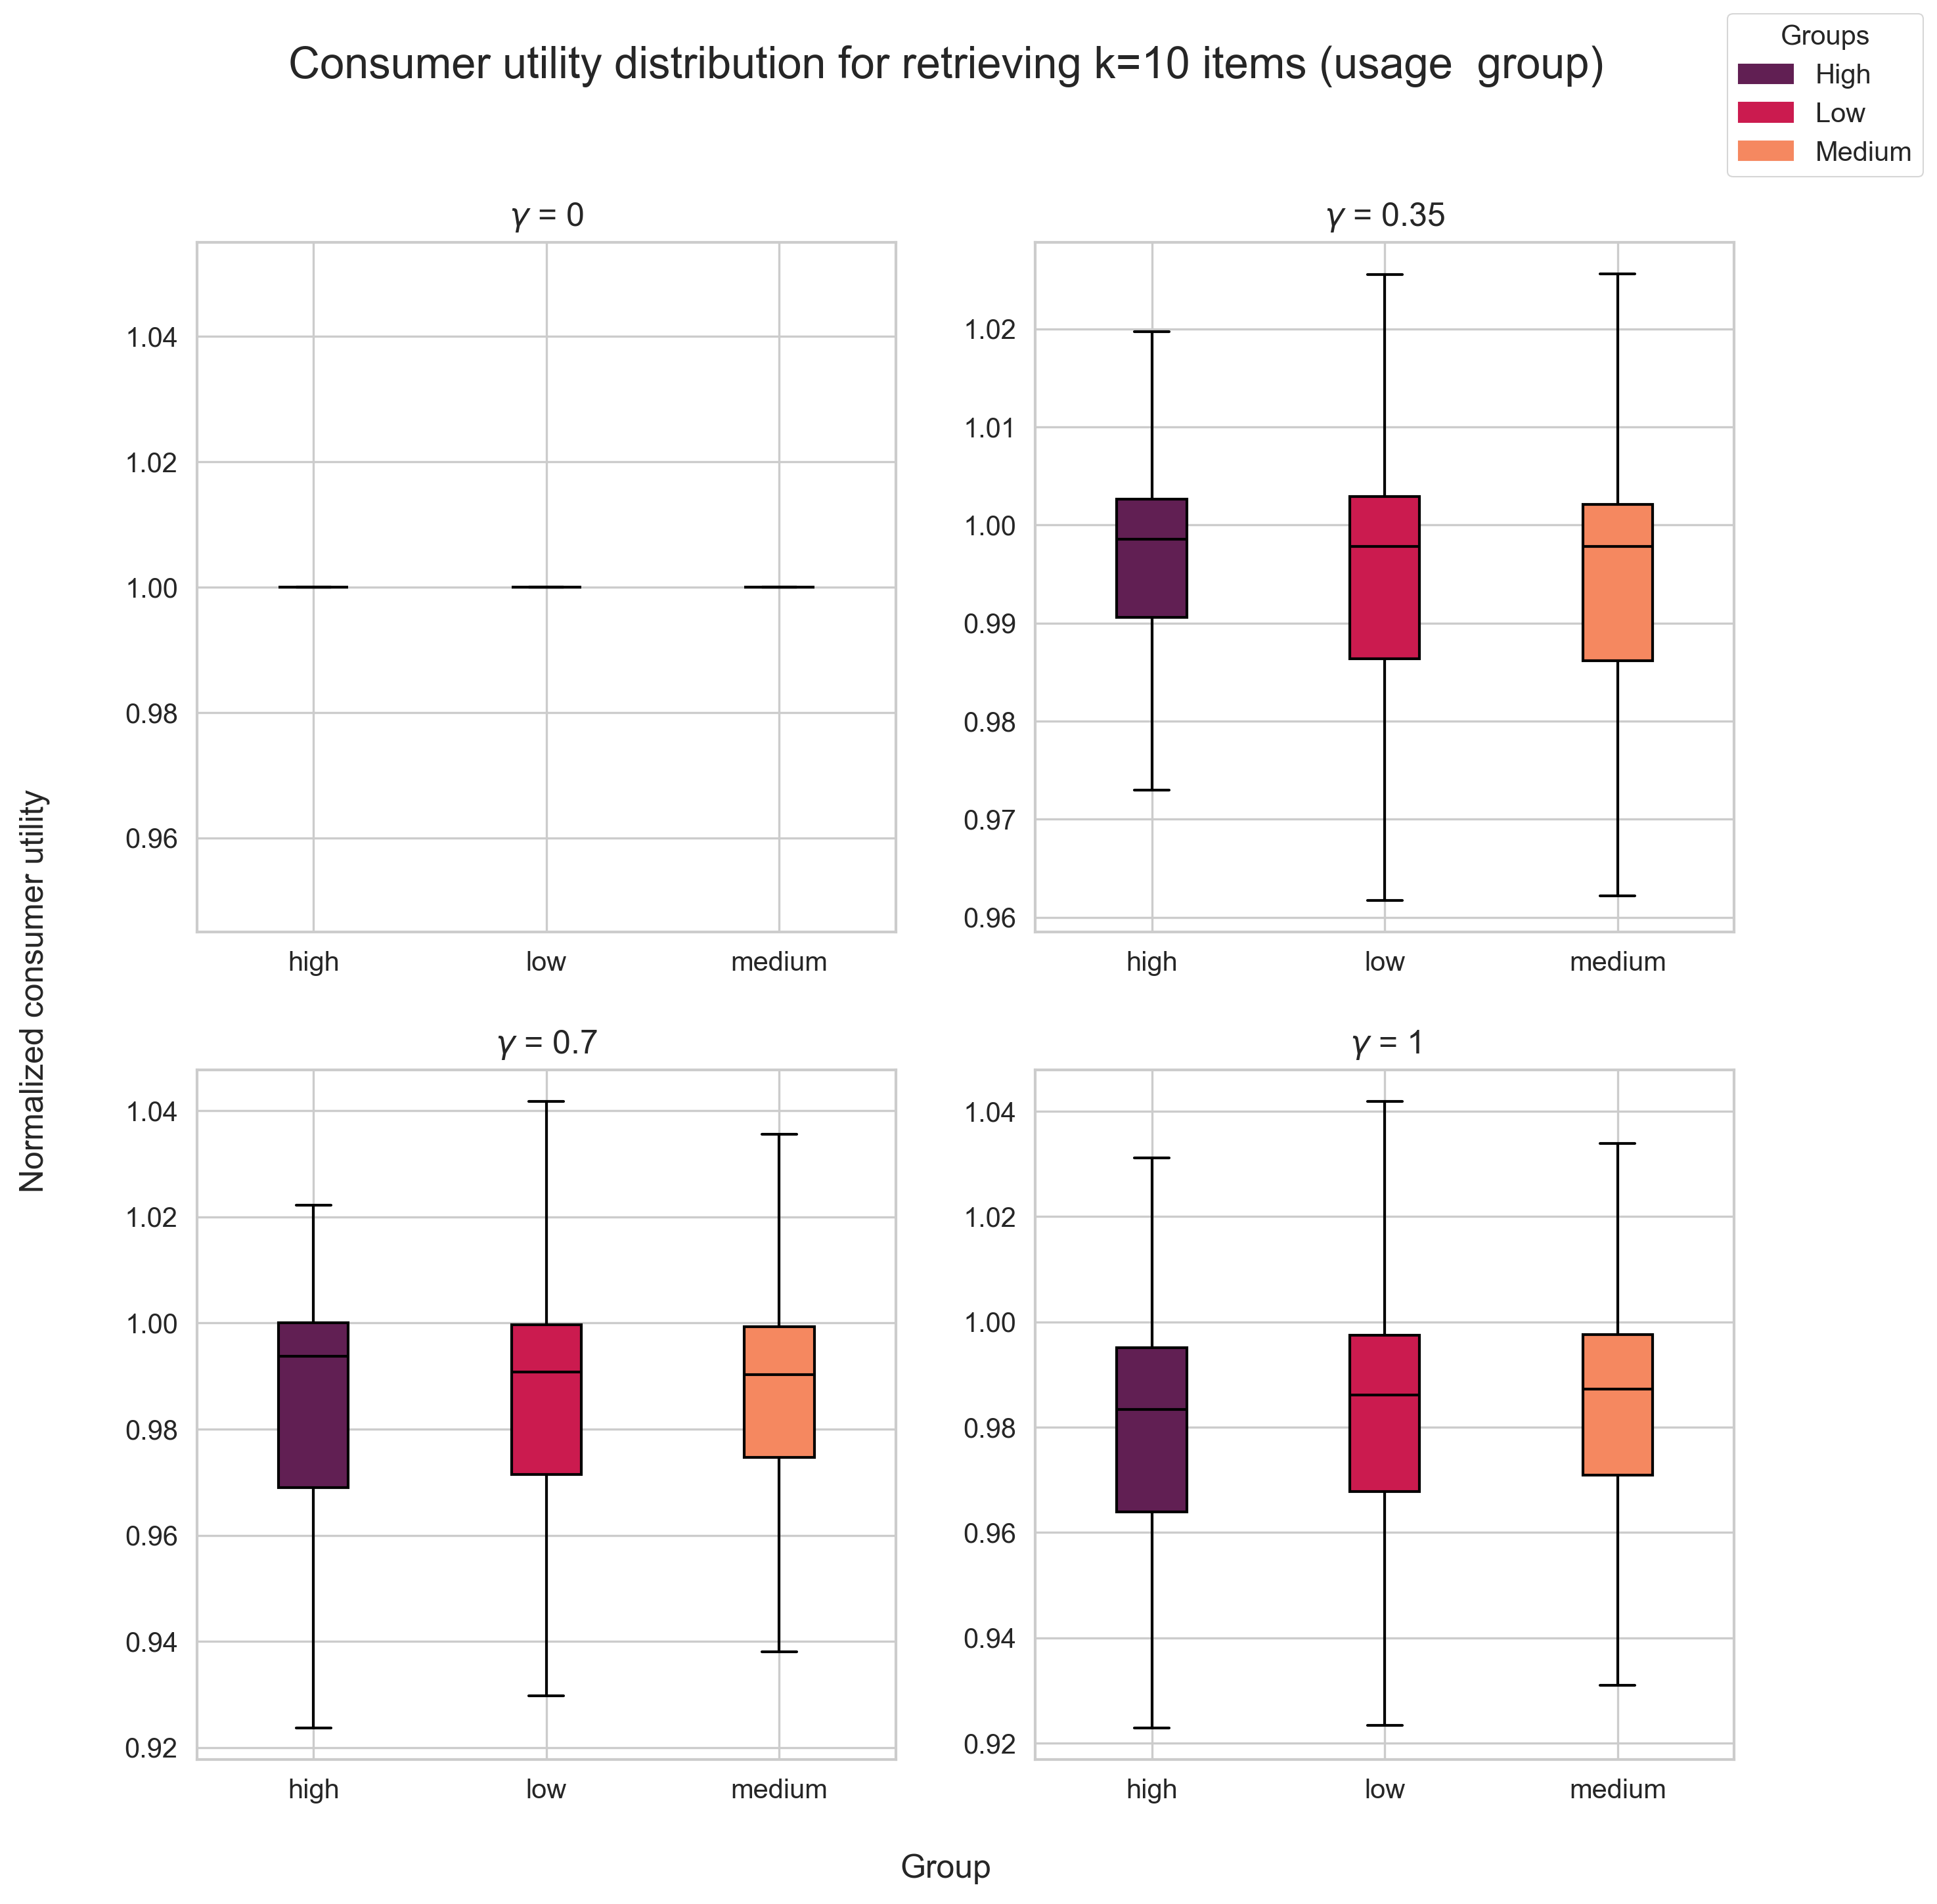

In [80]:
display_group_boxplots("min", users_ids, u_utils, user_groups, gamma_points, "usage_group", top_k, "./media21/")